In [1]:
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

batch_size = 250
epochs = 100
epochs_traits = 500
num_classes = 3

class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):

        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

def create_mlp(traitstrain, regularizer=None):
  """Creates a three-layer MLP with inputs of the given dimension"""
  model = Sequential()
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(150, use_bias=False, activation="relu"))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation="relu"))
  return model


def create_cnn(xtest, regularizer=None):
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv1D(250, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=3)(x)
  x = Flatten()(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model


2023-03-20 16:48:52.073766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 16:48:52.186357: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
traits_BM = []
traits_BM = np.loadtxt("../traits/traits_BM.txt").reshape(30000,-1,100)
traits_BM1 = np.array(traits_BM)
traits_BM1 = traits_BM1[0:10000]

traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(80000,-1,100)
traits_BM2 = np.array(traits_BM)
traits_BM2 = traits_BM2[0:60000]

traits_BM = []
traits_BM = np.concatenate((traits_BM1,traits_BM2))

#Use standard scaling for the continuous traits.
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i]) 


u1 = np.load("../trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp_01.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp_01.npz",mmap_mode='r')
u4 = np.load("./trainingSims/Model_2sp_05.npz",mmap_mode='r')
u5 = np.load("./trainingSims/Model_3sp_05.npz",mmap_mode='r')
u6 = np.load("./trainingSims/Model_2sp_1.npz",mmap_mode='r')
u7 = np.load("./trainingSims/Model_3sp_1.npz",mmap_mode='r')
#u8 = np.load("./Trained_Models/trainingSims/Migration/Model_2sp_5.npz",mmap_mode='r')
#u9 = np.load("./Trained_Models/trainingSims/Migration/Model_3sp_5.npz",mmap_mode='r')

u=np.concatenate((u1['Model_1sp'],u2['Model_2sp_01'],u3['Model_3sp_01'],u4['Model_2sp_05'],u5['Model_3sp_05'],u6['Model_2sp_1'],u7['Model_3sp_1']),axis=0)
#transform major alleles in -1 and minor 1
for arr,array in enumerate(u):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            u[arr][idx][u[arr][idx] == 1] = -1
            u[arr][idx][u[arr][idx] == 0] = 1
        else:
            u[arr][idx][u[arr][idx] == 0] = -1

In [3]:
################################################################################################################################################
#0.01 Migration 
################################################################################################################################################

X=u[0:30000,:,:]

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_BM01=traits_BM[0:30000,:,:]

print (len(X), len(y), len(traits_BM01))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM01 = traits_BM01[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM01[int(len(y)*.25):], traits_BM01[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-16 11:14:28.246247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 11:14:28.857627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22036 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration01_Trained_Comb_Model_100BM.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 250)     45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 250)    1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_2[0][

2023-03-16 11:14:34.117471: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-16 11:14:34.285788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-16 11:14:35.801733: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 11:14:35.803517: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 11:14:35.803540: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-16 11:14:35.805140: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 11:14:35.805206: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

90/90 [==============================] - 17s 124ms/step - loss: 10.8648 - accuracy: 0.4599 - val_loss: 10.8136 - val_accuracy: 0.5891
Epoch 2/100
90/90 [==============================] - 9s 106ms/step - loss: 10.5536 - accuracy: 0.6569 - val_loss: 10.5491 - val_accuracy: 0.7103
Epoch 3/100
90/90 [==============================] - 10s 112ms/step - loss: 10.3372 - accuracy: 0.7543 - val_loss: 10.2843 - val_accuracy: 0.7756
Epoch 4/100
90/90 [==============================] - 10s 106ms/step - loss: 10.1558 - accuracy: 0.8214 - val_loss: 10.0305 - val_accuracy: 0.8568
Epoch 5/100
90/90 [==============================] - 10s 112ms/step - loss: 10.0073 - accuracy: 0.8695 - val_loss: 9.8255 - val_accuracy: 0.9321
Epoch 6/100
90/90 [==============================] - 10s 114ms/step - loss: 9.8863 - accuracy: 0.9026 - val_loss: 9.6921 - val_accuracy: 0.9672
Epoch 7/100
90/90 [==============================] - 10s 107ms/step - loss: 9.7938 - accuracy: 0.9218 - val_loss: 9.6064 - val_accuracy: 0.9

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100BM.acc.mod/assets


In [5]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration01_Trained_CNN_Model.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d (Conv1D)             (None, 998, 250)          45000     
                                                                 
 batch_normalization_2 (Batc  (None, 998, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_3 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 994, 250)          1875

Epoch 38/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 7.5477e-04 - val_accuracy: 0.9999
Epoch 39/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 6.0797e-04 - val_accuracy: 0.9999
Epoch 40/100
90/90 [==============================] - 10s 107ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 6.4734e-04 - val_accuracy: 0.9997
Epoch 41/100
90/90 [==============================] - 10s 107ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 7.4720e-04 - val_accuracy: 0.9999
Epoch 42/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 7.4223e-04 - val_accuracy: 0.9999
Epoch 43/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 8.6146e-04 - val_accuracy: 0.9997
Epoch 44/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0062 - accuracy: 0.9981 - val_lo

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


In [6]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration01_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 3000)]            0         
                                                                 
 dense (Dense)               (None, 150)               450000    
                                                                 
 batch_normalization (BatchN  (None, 150)              600       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_1 (Batc  (None, 150)              600       
 hNormalization)                                         

90/90 [==============================] - 1s 9ms/step - loss: 3.4155 - accuracy: 0.9902 - val_loss: 3.8799 - val_accuracy: 0.7245
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3894 - accuracy: 0.9917 - val_loss: 3.8575 - val_accuracy: 0.7249
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3635 - accuracy: 0.9919 - val_loss: 3.8359 - val_accuracy: 0.7253
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3383 - accuracy: 0.9920 - val_loss: 3.8141 - val_accuracy: 0.7273
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3122 - accuracy: 0.9928 - val_loss: 3.7914 - val_accuracy: 0.7261
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2880 - accuracy: 0.9928 - val_loss: 3.7696 - val_accuracy: 0.7275
Epoch 110/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2613 - accuracy: 0.9940 - val_loss: 3.7478 - val_accuracy: 0.7285
Epoch 111/50

90/90 [==============================] - 1s 9ms/step - loss: 1.1777 - accuracy: 1.0000 - val_loss: 1.8361 - val_accuracy: 0.7633
Epoch 219/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1639 - accuracy: 1.0000 - val_loss: 1.8238 - val_accuracy: 0.7641
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1499 - accuracy: 1.0000 - val_loss: 1.8110 - val_accuracy: 0.7639
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1362 - accuracy: 1.0000 - val_loss: 1.7968 - val_accuracy: 0.7645
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1219 - accuracy: 1.0000 - val_loss: 1.7833 - val_accuracy: 0.7647
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1083 - accuracy: 1.0000 - val_loss: 1.7703 - val_accuracy: 0.7656
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0946 - accuracy: 1.0000 - val_loss: 1.7585 - val_accuracy: 0.7659
Epoch 2

90/90 [==============================] - 1s 9ms/step - loss: 0.8062 - accuracy: 0.8448 - val_loss: 1.2273 - val_accuracy: 0.7627
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5592 - accuracy: 0.9340 - val_loss: 1.0383 - val_accuracy: 0.7827
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4345 - accuracy: 0.9828 - val_loss: 0.9362 - val_accuracy: 0.7996
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3702 - accuracy: 0.9977 - val_loss: 0.8583 - val_accuracy: 0.8125
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3278 - accuracy: 1.0000 - val_loss: 0.8129 - val_accuracy: 0.8189
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2966 - accuracy: 1.0000 - val_loss: 0.7772 - val_accuracy: 0.8232
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2715 - accuracy: 1.0000 - val_loss: 0.7503 - val_accuracy: 0.8264
Epoch 339

90/90 [==============================] - 1s 10ms/step - loss: 0.1984 - accuracy: 1.0000 - val_loss: 0.5644 - val_accuracy: 0.8585
Epoch 390/500
90/90 [==============================] - 1s 12ms/step - loss: 0.1790 - accuracy: 1.0000 - val_loss: 0.5388 - val_accuracy: 0.8632
Epoch 391/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1632 - accuracy: 1.0000 - val_loss: 0.5197 - val_accuracy: 0.8660
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1488 - accuracy: 1.0000 - val_loss: 0.4993 - val_accuracy: 0.8669
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1390 - accuracy: 0.9999 - val_loss: 0.5079 - val_accuracy: 0.8676
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1968 - accuracy: 0.9843 - val_loss: 1.3966 - val_accuracy: 0.7643
Epoch 395/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6658 - accuracy: 0.8612 - val_loss: 1.0689 - val_accuracy: 0.7839
Epoch 396

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Traits_Model_100BM.acc.mod/assets


In [7]:
################################################################################################################################################
#0.05 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[30000:50000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_BM05=np.concatenate((traits_BM[0:10000,:,:],traits_BM[30000:50000,:,:]))

print (len(X), len(y), len(traits_BM05))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM05 = traits_BM05[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM05[int(len(y)*.25):], traits_BM05[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [8]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration05_Trained_Comb_Model_100BM.acc.mod')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 998, 250)     45000       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 998, 250)    1000        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_7[0][

90/90 [==============================] - 10s 109ms/step - loss: 7.1462 - accuracy: 0.9980 - val_loss: 7.1243 - val_accuracy: 0.9992
Epoch 73/100
90/90 [==============================] - 10s 108ms/step - loss: 7.1118 - accuracy: 0.9981 - val_loss: 7.0899 - val_accuracy: 0.9992
Epoch 74/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0775 - accuracy: 0.9984 - val_loss: 7.0556 - val_accuracy: 0.9992
Epoch 75/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0422 - accuracy: 0.9990 - val_loss: 7.0213 - val_accuracy: 0.9992
Epoch 76/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0083 - accuracy: 0.9987 - val_loss: 6.9871 - val_accuracy: 0.9992
Epoch 77/100
90/90 [==============================] - 10s 107ms/step - loss: 6.9748 - accuracy: 0.9984 - val_loss: 6.9531 - val_accuracy: 0.9992
Epoch 78/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9404 - accuracy: 0.9981 - val_loss: 6.9189 - val_accuracy: 0.999

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100BM.acc.mod/assets


In [9]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration05_Trained_CNN_Model.acc.mod')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_7 (Batc  (None, 998, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_8 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 994, 250)          1875

Epoch 95/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 96/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 98/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 99/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 100/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0014 - val_accuracy: 0.9995
Time: 948.8660700321198
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


In [10]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration05_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_10 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                         

90/90 [==============================] - 1s 10ms/step - loss: 3.3996 - accuracy: 0.9970 - val_loss: 3.8937 - val_accuracy: 0.7132
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3732 - accuracy: 0.9974 - val_loss: 3.8714 - val_accuracy: 0.7143
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3481 - accuracy: 0.9978 - val_loss: 3.8494 - val_accuracy: 0.7133
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3234 - accuracy: 0.9976 - val_loss: 3.8272 - val_accuracy: 0.7149
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2979 - accuracy: 0.9975 - val_loss: 3.8051 - val_accuracy: 0.7149
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2728 - accuracy: 0.9978 - val_loss: 3.7829 - val_accuracy: 0.7163
Epoch 110/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2481 - accuracy: 0.9980 - val_loss: 3.7609 - val_accuracy: 0.7164
Epoch 

90/90 [==============================] - 1s 10ms/step - loss: 2.1275 - accuracy: 1.0000 - val_loss: 2.7406 - val_accuracy: 0.7355
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1085 - accuracy: 1.0000 - val_loss: 2.7221 - val_accuracy: 0.7345
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0896 - accuracy: 1.0000 - val_loss: 2.7044 - val_accuracy: 0.7356
Epoch 164/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0705 - accuracy: 1.0000 - val_loss: 2.6868 - val_accuracy: 0.7351
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0514 - accuracy: 1.0000 - val_loss: 2.6691 - val_accuracy: 0.7365
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0323 - accuracy: 1.0000 - val_loss: 2.6510 - val_accuracy: 0.7364
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0141 - accuracy: 1.0000 - val_loss: 2.6341 - val_accuracy: 0.7357
Epoch 1

90/90 [==============================] - 1s 10ms/step - loss: 0.5175 - accuracy: 1.0000 - val_loss: 1.1828 - val_accuracy: 0.7695
Epoch 276/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5086 - accuracy: 1.0000 - val_loss: 1.1755 - val_accuracy: 0.7688
Epoch 277/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5000 - accuracy: 1.0000 - val_loss: 1.1651 - val_accuracy: 0.7687
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4909 - accuracy: 1.0000 - val_loss: 1.1585 - val_accuracy: 0.7696
Epoch 279/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4824 - accuracy: 1.0000 - val_loss: 1.1491 - val_accuracy: 0.7683
Epoch 280/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4738 - accuracy: 1.0000 - val_loss: 1.1408 - val_accuracy: 0.7703
Epoch 281/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4653 - accuracy: 1.0000 - val_loss: 1.1288 - val_accuracy: 0.7709
Epoch 28

90/90 [==============================] - 1s 10ms/step - loss: 0.3166 - accuracy: 0.9952 - val_loss: 0.6648 - val_accuracy: 0.8471
Epoch 390/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2669 - accuracy: 1.0000 - val_loss: 0.6042 - val_accuracy: 0.8592
Epoch 391/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2317 - accuracy: 1.0000 - val_loss: 0.5590 - val_accuracy: 0.8679
Epoch 392/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 0.5258 - val_accuracy: 0.8717
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1807 - accuracy: 1.0000 - val_loss: 0.4952 - val_accuracy: 0.8757
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1609 - accuracy: 1.0000 - val_loss: 0.4734 - val_accuracy: 0.8763
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1440 - accuracy: 1.0000 - val_loss: 0.4501 - val_accuracy: 0.8797
Epoch 396

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100BM.acc.mod/assets


In [41]:
################################################################################################################################################
#1 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[50000:70000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_BM1=np.concatenate((traits_BM[0:10000,:,:],traits_BM[50000:70000,:,:]))

print (len(X), len(y), len(traits_BM1))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM1 = traits_BM1[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM1[int(len(y)*.25):], traits_BM1[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [12]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration1_Trained_Comb_Model_100BM.acc.mod')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 998, 250)     45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 998, 250)    1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_12[0]

90/90 [==============================] - 10s 108ms/step - loss: 7.1606 - accuracy: 0.9984 - val_loss: 7.1367 - val_accuracy: 1.0000
Epoch 73/100
90/90 [==============================] - 10s 111ms/step - loss: 7.1260 - accuracy: 0.9985 - val_loss: 7.1022 - val_accuracy: 1.0000
Epoch 74/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0910 - accuracy: 0.9988 - val_loss: 7.0678 - val_accuracy: 1.0000
Epoch 75/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0564 - accuracy: 0.9985 - val_loss: 7.0335 - val_accuracy: 1.0000
Epoch 76/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0226 - accuracy: 0.9984 - val_loss: 6.9993 - val_accuracy: 1.0000
Epoch 77/100
90/90 [==============================] - 10s 109ms/step - loss: 6.9891 - accuracy: 0.9981 - val_loss: 6.9652 - val_accuracy: 1.0000
Epoch 78/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9546 - accuracy: 0.9984 - val_loss: 6.9312 - val_accuracy: 1.000

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100BM.acc.mod/assets


In [13]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration1_Trained_CNN_Model.acc.mod')

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_12 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_13 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_8 (Conv1D)           (None, 994, 250)          187

90/90 [==============================] - 9s 105ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 1.9698e-04 - val_accuracy: 0.9999
Epoch 93/100
90/90 [==============================] - 9s 106ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 2.0772e-04 - val_accuracy: 0.9999
Epoch 94/100
90/90 [==============================] - 10s 107ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 1.9567e-04 - val_accuracy: 0.9999
Epoch 95/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 1.9468e-04 - val_accuracy: 0.9999
Epoch 96/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 1.7533e-04 - val_accuracy: 0.9999
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 2.0572e-04 - val_accuracy: 0.9999
Epoch 98/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 1.8607e-0

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


In [42]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration1_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8_input (InputLayer)  [(None, 3000)]            0         
                                                                 
 dense_8 (Dense)             (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                         

Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2431 - accuracy: 0.9616 - val_loss: 6.5923 - val_accuracy: 0.6936
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2089 - accuracy: 0.9626 - val_loss: 6.5617 - val_accuracy: 0.6936
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1739 - accuracy: 0.9647 - val_loss: 6.5313 - val_accuracy: 0.6941
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1393 - accuracy: 0.9661 - val_loss: 6.5011 - val_accuracy: 0.6941
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1049 - accuracy: 0.9660 - val_loss: 6.4708 - val_accuracy: 0.6945
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0701 - accuracy: 0.9672 - val_loss: 6.4407 - val_accuracy: 0.6951
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0364 - accuracy: 0.9700 - val_loss: 6.4106 - val_accuracy: 0.6960

90/90 [==============================] - 1s 9ms/step - loss: 2.9889 - accuracy: 1.0000 - val_loss: 3.6787 - val_accuracy: 0.7151
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9665 - accuracy: 1.0000 - val_loss: 3.6574 - val_accuracy: 0.7151
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9442 - accuracy: 1.0000 - val_loss: 3.6367 - val_accuracy: 0.7147
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9215 - accuracy: 1.0000 - val_loss: 3.6157 - val_accuracy: 0.7148
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8986 - accuracy: 1.0000 - val_loss: 3.5949 - val_accuracy: 0.7160
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8767 - accuracy: 1.0000 - val_loss: 3.5743 - val_accuracy: 0.7161
Epoch 225/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8546 - accuracy: 1.0000 - val_loss: 3.5536 - val_accuracy: 0.7156
Epoch 226/500

90/90 [==============================] - 1s 10ms/step - loss: 0.9756 - accuracy: 1.0000 - val_loss: 1.7991 - val_accuracy: 0.7285
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9629 - accuracy: 1.0000 - val_loss: 1.7854 - val_accuracy: 0.7293
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9505 - accuracy: 1.0000 - val_loss: 1.7735 - val_accuracy: 0.7299
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.9380 - accuracy: 1.0000 - val_loss: 1.7631 - val_accuracy: 0.7293
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.9256 - accuracy: 1.0000 - val_loss: 1.7518 - val_accuracy: 0.7293
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9136 - accuracy: 1.0000 - val_loss: 1.7388 - val_accuracy: 0.7292
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9013 - accuracy: 1.0000 - val_loss: 1.7291 - val_accuracy: 0.7296
Epoch 340/

90/90 [==============================] - 1s 10ms/step - loss: 0.1694 - accuracy: 1.0000 - val_loss: 0.8847 - val_accuracy: 0.7661
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1709 - accuracy: 0.9979 - val_loss: 1.2505 - val_accuracy: 0.7429
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8752 - accuracy: 0.8164 - val_loss: 1.5291 - val_accuracy: 0.7140
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5671 - accuracy: 0.9292 - val_loss: 1.1815 - val_accuracy: 0.7504
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4214 - accuracy: 0.9888 - val_loss: 1.0462 - val_accuracy: 0.7604
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3577 - accuracy: 0.9996 - val_loss: 0.9736 - val_accuracy: 0.7644
Epoch 453/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3183 - accuracy: 1.0000 - val_loss: 0.9274 - val_accuracy: 0.7680
Epoch 454/

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100BM.acc.mod/assets


In [24]:
traits_OU = []
traits_OU = np.loadtxt("../traits/traits_OU.txt").reshape(30000,-1,100)
traits_OU1 = np.array(traits_OU)
traits_OU1 = traits_OU1[0:10000]

traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(80000,-1,100)
traits_OU2 = np.array(traits_OU)
traits_OU2 = traits_OU2[0:60000]

traits_OU = []
traits_OU = np.concatenate((traits_OU1,traits_OU2))

#Use standard scaling for the continuous traits
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

In [16]:
################################################################################################################################################
#0.01 Migration 
################################################################################################################################################

X=u[0:30000,:,:]

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_OU01=traits_OU[0:30000,:,:]

print (len(X), len(y), len(traits_OU01))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU01 = traits_OU01[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU01[int(len(y)*.25):], traits_OU01[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [17]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration01_Trained_Comb_Model_100OU.acc.mod')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 250)     45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 998, 250)    1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_17[0

90/90 [==============================] - 10s 108ms/step - loss: 7.1417 - accuracy: 0.9971 - val_loss: 7.1143 - val_accuracy: 0.9999
Epoch 73/100
90/90 [==============================] - 10s 108ms/step - loss: 7.1053 - accuracy: 0.9983 - val_loss: 7.0798 - val_accuracy: 0.9999
Epoch 74/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0712 - accuracy: 0.9978 - val_loss: 7.0455 - val_accuracy: 0.9999
Epoch 75/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0370 - accuracy: 0.9977 - val_loss: 7.0113 - val_accuracy: 0.9999
Epoch 76/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0034 - accuracy: 0.9976 - val_loss: 6.9770 - val_accuracy: 0.9999
Epoch 77/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9685 - accuracy: 0.9978 - val_loss: 6.9428 - val_accuracy: 0.9999
Epoch 78/100
90/90 [==============================] - 10s 110ms/step - loss: 6.9355 - accuracy: 0.9970 - val_loss: 6.9089 - val_accuracy: 0.999

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100OU.acc.mod/assets


In [18]:
################################################################################################################################################
#50 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration01_Trained_CNN_Model.acc.mod')

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_9 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_17 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_10 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_18 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 994, 250)          187

90/90 [==============================] - 9s 105ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 3.6119e-04 - val_accuracy: 0.9999
Epoch 93/100
90/90 [==============================] - 10s 107ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 4.0706e-04 - val_accuracy: 0.9997
Epoch 94/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 4.5995e-04 - val_accuracy: 0.9997
Epoch 95/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 4.1074e-04 - val_accuracy: 0.9997
Epoch 96/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 3.9197e-04 - val_accuracy: 0.9997
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 3.4745e-04 - val_accuracy: 0.9999
Epoch 98/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 3.9781e-04

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


In [19]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration01_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_30 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_15 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_16 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 5.0853 - accuracy: 0.9185 - val_loss: 5.3917 - val_accuracy: 0.6748
Epoch 48/500
90/90 [==============================] - 1s 10ms/step - loss: 5.0505 - accuracy: 0.9210 - val_loss: 5.3620 - val_accuracy: 0.6755
Epoch 49/500
90/90 [==============================] - 1s 10ms/step - loss: 5.0160 - accuracy: 0.9263 - val_loss: 5.3325 - val_accuracy: 0.6764
Epoch 50/500
90/90 [==============================] - 1s 10ms/step - loss: 4.9825 - accuracy: 0.9292 - val_loss: 5.3029 - val_accuracy: 0.6776
Epoch 51/500
90/90 [==============================] - 1s 10ms/step - loss: 4.9483 - accuracy: 0.9301 - val_loss: 5.2735 - val_accuracy: 0.6791
Epoch 52/500
90/90 [==============================] - 1s 10ms/step - loss: 4.9153 - accuracy: 0.9342 - val_loss: 5.2445 - val_accuracy: 0.6805
Epoch 53/500
90/90 [==============================] - 1s 10ms/step - loss: 4.8812 - accuracy: 0.9377 - val_loss: 5.2154 - val_accuracy: 0.6817
Epoch 54/500

90/90 [==============================] - 1s 10ms/step - loss: 2.1158 - accuracy: 1.0000 - val_loss: 2.6741 - val_accuracy: 0.7613
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0969 - accuracy: 1.0000 - val_loss: 2.6551 - val_accuracy: 0.7612
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0773 - accuracy: 1.0000 - val_loss: 2.6361 - val_accuracy: 0.7609
Epoch 164/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0588 - accuracy: 1.0000 - val_loss: 2.6170 - val_accuracy: 0.7619
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0395 - accuracy: 1.0000 - val_loss: 2.5984 - val_accuracy: 0.7623
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0208 - accuracy: 1.0000 - val_loss: 2.5799 - val_accuracy: 0.7628
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0025 - accuracy: 1.0000 - val_loss: 2.5612 - val_accuracy: 0.7631
Epoch 

90/90 [==============================] - 1s 9ms/step - loss: 0.5174 - accuracy: 1.0000 - val_loss: 1.0406 - val_accuracy: 0.8093
Epoch 276/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5084 - accuracy: 1.0000 - val_loss: 1.0308 - val_accuracy: 0.8101
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5002 - accuracy: 1.0000 - val_loss: 1.0206 - val_accuracy: 0.8125
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4912 - accuracy: 1.0000 - val_loss: 1.0144 - val_accuracy: 0.8099
Epoch 279/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4830 - accuracy: 1.0000 - val_loss: 1.0044 - val_accuracy: 0.8113
Epoch 280/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4742 - accuracy: 1.0000 - val_loss: 0.9960 - val_accuracy: 0.8113
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4657 - accuracy: 1.0000 - val_loss: 0.9881 - val_accuracy: 0.8135
Epoch 282/500

90/90 [==============================] - 1s 11ms/step - loss: 0.1157 - accuracy: 0.9981 - val_loss: 0.6957 - val_accuracy: 0.8452
Epoch 390/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5104 - accuracy: 0.9063 - val_loss: 1.3676 - val_accuracy: 0.7088
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3918 - accuracy: 0.9651 - val_loss: 0.6412 - val_accuracy: 0.8793
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3002 - accuracy: 0.9959 - val_loss: 0.5424 - val_accuracy: 0.8984
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2513 - accuracy: 1.0000 - val_loss: 0.5361 - val_accuracy: 0.8904
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2174 - accuracy: 1.0000 - val_loss: 0.5262 - val_accuracy: 0.8828
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1900 - accuracy: 1.0000 - val_loss: 0.5090 - val_accuracy: 0.8812
Epoch 396/5

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Traits_Model_100OU.acc.mod/assets


In [20]:
################################################################################################################################################
#0.05 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[30000:50000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_OU05=np.concatenate((traits_OU[0:10000,:,:],traits_OU[30000:50000,:,:]))

print (len(X), len(y), len(traits_OU05))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU05 = traits_OU05[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU05[int(len(y)*.25):], traits_OU05[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [21]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration05_Trained_Comb_Model_100OU.acc.mod')

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 998, 250)     45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 998, 250)    1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_22[0

90/90 [==============================] - 10s 108ms/step - loss: 7.1426 - accuracy: 0.9977 - val_loss: 7.1184 - val_accuracy: 0.9996
Epoch 73/100
90/90 [==============================] - 10s 108ms/step - loss: 7.1080 - accuracy: 0.9979 - val_loss: 7.0840 - val_accuracy: 0.9996
Epoch 74/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0734 - accuracy: 0.9980 - val_loss: 7.0496 - val_accuracy: 0.9997
Epoch 75/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0387 - accuracy: 0.9979 - val_loss: 7.0153 - val_accuracy: 0.9997
Epoch 76/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0041 - accuracy: 0.9980 - val_loss: 6.9811 - val_accuracy: 0.9997
Epoch 77/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9697 - accuracy: 0.9983 - val_loss: 6.9470 - val_accuracy: 0.9997
Epoch 78/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9357 - accuracy: 0.9981 - val_loss: 6.9129 - val_accuracy: 0.999

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100OU.acc.mod/assets


In [22]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration05_Trained_CNN_Model.acc.mod')

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 998, 250)          45000     
                                                                 
 batch_normalization_22 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_23 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_14 (Conv1D)          (None, 994, 250)          187

Epoch 95/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 96/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 98/100
90/90 [==============================] - 10s 107ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 99/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 100/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0017 - val_accuracy: 0.9997
Time: 947.1350710391998
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


In [23]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration05_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_40 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_20 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_21 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 3.3655 - accuracy: 0.9994 - val_loss: 3.9103 - val_accuracy: 0.7248
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3399 - accuracy: 0.9996 - val_loss: 3.8872 - val_accuracy: 0.7259
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3155 - accuracy: 0.9996 - val_loss: 3.8648 - val_accuracy: 0.7268
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2909 - accuracy: 0.9996 - val_loss: 3.8424 - val_accuracy: 0.7264
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2658 - accuracy: 0.9996 - val_loss: 3.8197 - val_accuracy: 0.7263
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2423 - accuracy: 0.9997 - val_loss: 3.7975 - val_accuracy: 0.7267
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2172 - accuracy: 0.9997 - val_loss: 3.7753 - val_accuracy: 0.7267
Epoch 111/50

90/90 [==============================] - 1s 10ms/step - loss: 1.1710 - accuracy: 1.0000 - val_loss: 1.8229 - val_accuracy: 0.7592
Epoch 219/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1571 - accuracy: 1.0000 - val_loss: 1.8099 - val_accuracy: 0.7587
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1433 - accuracy: 1.0000 - val_loss: 1.7968 - val_accuracy: 0.7601
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1294 - accuracy: 1.0000 - val_loss: 1.7832 - val_accuracy: 0.7608
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1157 - accuracy: 1.0000 - val_loss: 1.7702 - val_accuracy: 0.7612
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1019 - accuracy: 1.0000 - val_loss: 1.7568 - val_accuracy: 0.7608
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0885 - accuracy: 1.0000 - val_loss: 1.7441 - val_accuracy: 0.7608
Epoch 

90/90 [==============================] - 1s 9ms/step - loss: 0.4306 - accuracy: 0.9960 - val_loss: 0.8885 - val_accuracy: 0.8212
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3803 - accuracy: 1.0000 - val_loss: 0.8434 - val_accuracy: 0.8193
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3442 - accuracy: 1.0000 - val_loss: 0.8124 - val_accuracy: 0.8173
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3140 - accuracy: 1.0000 - val_loss: 0.7834 - val_accuracy: 0.8185
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2872 - accuracy: 1.0000 - val_loss: 0.7581 - val_accuracy: 0.8181
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2638 - accuracy: 1.0000 - val_loss: 0.7334 - val_accuracy: 0.8168
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2424 - accuracy: 1.0000 - val_loss: 0.7121 - val_accuracy: 0.8203
Epoch 339/5

90/90 [==============================] - 1s 9ms/step - loss: 0.1682 - accuracy: 1.0000 - val_loss: 0.4444 - val_accuracy: 0.8845
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1478 - accuracy: 1.0000 - val_loss: 0.4272 - val_accuracy: 0.8847
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1300 - accuracy: 1.0000 - val_loss: 0.4108 - val_accuracy: 0.8864
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1152 - accuracy: 1.0000 - val_loss: 0.3987 - val_accuracy: 0.8868
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1026 - accuracy: 1.0000 - val_loss: 0.3883 - val_accuracy: 0.8897
Epoch 451/500
90/90 [==============================] - 1s 11ms/step - loss: 0.0926 - accuracy: 1.0000 - val_loss: 0.3726 - val_accuracy: 0.8916
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.3652 - val_accuracy: 0.8972
Epoch 453/

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100OU.acc.mod/assets


In [28]:
################################################################################################################################################
#1 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[50000:70000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_OU1=np.concatenate((traits_OU[0:10000,:,:],traits_OU[50000:70000,:,:]))

print (len(X), len(y), len(traits_OU1))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU1 = traits_OU1[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU1[int(len(y)*.25):], traits_OU1[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [29]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration1_Trained_Comb_Model_100OU.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 250)     45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 250)    1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_2[0][

Epoch 73/100
90/90 [==============================] - 10s 111ms/step - loss: 7.1100 - accuracy: 0.9976 - val_loss: 7.0846 - val_accuracy: 1.0000
Epoch 74/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0754 - accuracy: 0.9978 - val_loss: 7.0502 - val_accuracy: 1.0000
Epoch 75/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0412 - accuracy: 0.9976 - val_loss: 7.0159 - val_accuracy: 1.0000
Epoch 76/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0065 - accuracy: 0.9978 - val_loss: 6.9817 - val_accuracy: 1.0000
Epoch 77/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9718 - accuracy: 0.9981 - val_loss: 6.9475 - val_accuracy: 1.0000
Epoch 78/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9370 - accuracy: 0.9983 - val_loss: 6.9135 - val_accuracy: 1.0000
Epoch 79/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9032 - accuracy: 0.9982 - val_loss: 6.8795 - val_accur

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100OU.acc.mod/assets


In [26]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration1_Trained_CNN_Model.acc.mod')

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_15 (Conv1D)          (None, 998, 250)          45000     
                                                                 
 batch_normalization_27 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_16 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_28 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 994, 250)          187

Epoch 95/100
90/90 [==============================] - 9s 103ms/step - loss: 0.4746 - accuracy: 0.8811 - val_loss: 1.4782 - val_accuracy: 0.3273
Epoch 96/100
90/90 [==============================] - 9s 103ms/step - loss: 0.4650 - accuracy: 0.8848 - val_loss: 1.4131 - val_accuracy: 0.3380
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.4917 - accuracy: 0.8642 - val_loss: 1.5151 - val_accuracy: 0.3309
Epoch 98/100
90/90 [==============================] - 9s 103ms/step - loss: 0.4915 - accuracy: 0.8634 - val_loss: 1.4548 - val_accuracy: 0.3360
Epoch 99/100
90/90 [==============================] - 9s 103ms/step - loss: 0.4727 - accuracy: 0.8787 - val_loss: 1.3908 - val_accuracy: 0.3301
Epoch 100/100
90/90 [==============================] - 9s 103ms/step - loss: 0.4550 - accuracy: 0.8849 - val_loss: 1.4691 - val_accuracy: 0.3348
Time: 939.6068592071533
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_6'

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


In [27]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration1_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_50 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_25 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_51 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_26 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 3.3670 - accuracy: 0.9988 - val_loss: 3.9609 - val_accuracy: 0.7028
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3422 - accuracy: 0.9990 - val_loss: 3.9394 - val_accuracy: 0.7027
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3168 - accuracy: 0.9989 - val_loss: 3.9178 - val_accuracy: 0.7025
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2913 - accuracy: 0.9992 - val_loss: 3.8961 - val_accuracy: 0.7039
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2669 - accuracy: 0.9993 - val_loss: 3.8748 - val_accuracy: 0.7052
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2423 - accuracy: 0.9995 - val_loss: 3.8533 - val_accuracy: 0.7041
Epoch 110/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2181 - accuracy: 0.9993 - val_loss: 3.8324 - val_accuracy: 0.7043
Epoch 111

90/90 [==============================] - 1s 10ms/step - loss: 1.1728 - accuracy: 1.0000 - val_loss: 1.9471 - val_accuracy: 0.7291
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1590 - accuracy: 1.0000 - val_loss: 1.9336 - val_accuracy: 0.7292
Epoch 220/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1452 - accuracy: 1.0000 - val_loss: 1.9208 - val_accuracy: 0.7292
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1311 - accuracy: 1.0000 - val_loss: 1.9068 - val_accuracy: 0.7299
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1177 - accuracy: 1.0000 - val_loss: 1.8934 - val_accuracy: 0.7305
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1040 - accuracy: 1.0000 - val_loss: 1.8808 - val_accuracy: 0.7305
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0905 - accuracy: 1.0000 - val_loss: 1.8684 - val_accuracy: 0.7316
Epoch 22

90/90 [==============================] - 1s 10ms/step - loss: 0.2424 - accuracy: 1.0000 - val_loss: 0.8773 - val_accuracy: 0.7808
Epoch 333/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2272 - accuracy: 1.0000 - val_loss: 0.8675 - val_accuracy: 0.7811
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2142 - accuracy: 1.0000 - val_loss: 0.8581 - val_accuracy: 0.7809
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2025 - accuracy: 1.0000 - val_loss: 0.8546 - val_accuracy: 0.7812
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1924 - accuracy: 1.0000 - val_loss: 0.8456 - val_accuracy: 0.7801
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1832 - accuracy: 1.0000 - val_loss: 0.8443 - val_accuracy: 0.7779
Epoch 338/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1745 - accuracy: 1.0000 - val_loss: 0.8424 - val_accuracy: 0.7804
Epoch 3

90/90 [==============================] - 1s 9ms/step - loss: 0.2277 - accuracy: 1.0000 - val_loss: 0.5929 - val_accuracy: 0.8549
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.8536
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1780 - accuracy: 1.0000 - val_loss: 0.5441 - val_accuracy: 0.8563
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 0.5209 - val_accuracy: 0.8575
Epoch 450/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1406 - accuracy: 1.0000 - val_loss: 0.5025 - val_accuracy: 0.8612
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1255 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.8599
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1128 - accuracy: 1.0000 - val_loss: 0.4758 - val_accuracy: 0.8619
Epoch 453/5

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100OU.acc.mod/assets


In [3]:
traits_discrete = []
traits_discrete = np.loadtxt("../traits/traits_disc.txt").reshape(30000,-1,100)

traits_discrete1 = np.array(traits_discrete)
traits_discrete1 = traits_discrete1[0:10000]

traits_discrete = []
traits_discrete = np.loadtxt("./traits/traits_disc.txt").reshape(80000,-1,100)

traits_discrete2 = np.array(traits_discrete)
traits_discrete2 = traits_discrete2[0:60000]

traits_discrete = []
traits_discrete = np.concatenate((traits_discrete1,traits_discrete2))

In [4]:
################################################################################################################################################
#0.01 Migration 
################################################################################################################################################

X=u[0:30000,:,:]

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_discrete01=traits_discrete[0:30000,:,:]

print (len(X), len(y), len(traits_discrete01))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete01 = traits_discrete01[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete01[int(len(y)*.25):], traits_discrete01[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-20 16:57:55.112280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 16:57:55.724195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22110 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [30]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration01_Trained_Comb_Model_100discrete.acc.mod')

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 998, 250)     45000       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 998, 250)    1000        ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_32[0

90/90 [==============================] - 10s 106ms/step - loss: 7.1455 - accuracy: 0.9973 - val_loss: 7.1187 - val_accuracy: 0.9996
Epoch 73/100
90/90 [==============================] - 10s 108ms/step - loss: 7.1108 - accuracy: 0.9968 - val_loss: 7.0843 - val_accuracy: 0.9996
Epoch 74/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0777 - accuracy: 0.9969 - val_loss: 7.0498 - val_accuracy: 0.9997
Epoch 75/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0431 - accuracy: 0.9966 - val_loss: 7.0155 - val_accuracy: 0.9997
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0095 - accuracy: 0.9965 - val_loss: 6.9815 - val_accuracy: 0.9996
Epoch 77/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9735 - accuracy: 0.9971 - val_loss: 6.9475 - val_accuracy: 0.9996
Epoch 78/100
90/90 [==============================] - 10s 107ms/step - loss: 6.9389 - accuracy: 0.9979 - val_loss: 6.9134 - val_accuracy: 0.999

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Comb_Model_100discrete.acc.mod/assets


In [31]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration01_Trained_CNN_Model.acc.mod')

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_18 (Conv1D)          (None, 998, 250)          45000     
                                                                 
 batch_normalization_32 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_19 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_33 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (None, 994, 250)          187

Epoch 38/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 5.5949e-04 - val_accuracy: 0.9999
Epoch 39/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 4.8894e-04 - val_accuracy: 0.9999
Epoch 40/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 5.8305e-04 - val_accuracy: 0.9999
Epoch 41/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0088 - accuracy: 0.9968 - val_loss: 5.0582e-04 - val_accuracy: 0.9999
Epoch 42/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 6.5589e-04 - val_accuracy: 0.9999
Epoch 43/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 5.2908e-04 - val_accuracy: 0.9999
Epoch 44/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_CNN_Model.acc.mod/assets


In [5]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration01_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 3000)]            0         
                                                                 
 dense (Dense)               (None, 150)               450000    
                                                                 
 batch_normalization (BatchN  (None, 150)              600       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_1 (Batc  (None, 150)              600       
 hNormalization)                                   

2023-03-20 16:57:59.284447: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


90/90 [==============================] - 3s 14ms/step - loss: 11.2294 - accuracy: 0.3319 - val_loss: 10.9996 - val_accuracy: 0.3352
Epoch 2/500
90/90 [==============================] - 1s 8ms/step - loss: 11.1040 - accuracy: 0.3407 - val_loss: 10.9701 - val_accuracy: 0.3343
Epoch 3/500
90/90 [==============================] - 1s 9ms/step - loss: 11.0125 - accuracy: 0.3485 - val_loss: 10.9585 - val_accuracy: 0.3333
Epoch 4/500
90/90 [==============================] - 1s 9ms/step - loss: 10.9336 - accuracy: 0.3538 - val_loss: 10.9227 - val_accuracy: 0.3365
Epoch 5/500
90/90 [==============================] - 1s 9ms/step - loss: 10.8669 - accuracy: 0.3600 - val_loss: 10.8946 - val_accuracy: 0.3375
Epoch 6/500
90/90 [==============================] - 1s 9ms/step - loss: 10.8032 - accuracy: 0.3677 - val_loss: 10.8289 - val_accuracy: 0.3333
Epoch 7/500
90/90 [==============================] - 1s 9ms/step - loss: 10.7444 - accuracy: 0.3732 - val_loss: 10.7846 - val_accuracy: 0.3408
Epoch 8/50

90/90 [==============================] - 1s 8ms/step - loss: 8.4232 - accuracy: 0.6739 - val_loss: 8.7500 - val_accuracy: 0.3939
Epoch 59/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3794 - accuracy: 0.6772 - val_loss: 8.7117 - val_accuracy: 0.3959
Epoch 60/500
90/90 [==============================] - 1s 8ms/step - loss: 8.3381 - accuracy: 0.6855 - val_loss: 8.6753 - val_accuracy: 0.3995
Epoch 61/500
90/90 [==============================] - 1s 8ms/step - loss: 8.2946 - accuracy: 0.6896 - val_loss: 8.6439 - val_accuracy: 0.3993
Epoch 62/500
90/90 [==============================] - 1s 8ms/step - loss: 8.2543 - accuracy: 0.6946 - val_loss: 8.6072 - val_accuracy: 0.3949
Epoch 63/500
90/90 [==============================] - 1s 9ms/step - loss: 8.2125 - accuracy: 0.6999 - val_loss: 8.5699 - val_accuracy: 0.4009
Epoch 64/500
90/90 [==============================] - 1s 8ms/step - loss: 8.1703 - accuracy: 0.7016 - val_loss: 8.5372 - val_accuracy: 0.3935
Epoch 65/500
90/90 

Epoch 116/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1054 - accuracy: 0.9096 - val_loss: 6.8736 - val_accuracy: 0.4387
Epoch 117/500
90/90 [==============================] - 1s 8ms/step - loss: 6.0690 - accuracy: 0.9127 - val_loss: 6.8494 - val_accuracy: 0.4393
Epoch 118/500
90/90 [==============================] - 1s 8ms/step - loss: 6.0321 - accuracy: 0.9126 - val_loss: 6.8134 - val_accuracy: 0.4405
Epoch 119/500
90/90 [==============================] - 1s 9ms/step - loss: 5.9954 - accuracy: 0.9168 - val_loss: 6.7752 - val_accuracy: 0.4440
Epoch 120/500
90/90 [==============================] - 1s 9ms/step - loss: 5.9573 - accuracy: 0.9207 - val_loss: 6.7578 - val_accuracy: 0.4432
Epoch 121/500
90/90 [==============================] - 1s 8ms/step - loss: 5.9220 - accuracy: 0.9217 - val_loss: 6.7291 - val_accuracy: 0.4404
Epoch 122/500
90/90 [==============================] - 1s 9ms/step - loss: 5.8857 - accuracy: 0.9244 - val_loss: 6.7074 - val_accuracy: 0.4475

90/90 [==============================] - 1s 8ms/step - loss: 4.2176 - accuracy: 0.9939 - val_loss: 5.3891 - val_accuracy: 0.4656
Epoch 174/500
90/90 [==============================] - 1s 8ms/step - loss: 4.1892 - accuracy: 0.9937 - val_loss: 5.3650 - val_accuracy: 0.4705
Epoch 175/500
90/90 [==============================] - 1s 9ms/step - loss: 4.1617 - accuracy: 0.9947 - val_loss: 5.3406 - val_accuracy: 0.4679
Epoch 176/500
90/90 [==============================] - 1s 8ms/step - loss: 4.1326 - accuracy: 0.9950 - val_loss: 5.3148 - val_accuracy: 0.4679
Epoch 177/500
90/90 [==============================] - 1s 9ms/step - loss: 4.1031 - accuracy: 0.9952 - val_loss: 5.2974 - val_accuracy: 0.4707
Epoch 178/500
90/90 [==============================] - 1s 8ms/step - loss: 4.0767 - accuracy: 0.9950 - val_loss: 5.2812 - val_accuracy: 0.4688
Epoch 179/500
90/90 [==============================] - 1s 9ms/step - loss: 4.0470 - accuracy: 0.9956 - val_loss: 5.2427 - val_accuracy: 0.4705
Epoch 180/500

90/90 [==============================] - 1s 9ms/step - loss: 2.7733 - accuracy: 0.9998 - val_loss: 4.1792 - val_accuracy: 0.4852
Epoch 231/500
90/90 [==============================] - 1s 8ms/step - loss: 2.7522 - accuracy: 0.9997 - val_loss: 4.1587 - val_accuracy: 0.4871
Epoch 232/500
90/90 [==============================] - 1s 9ms/step - loss: 2.7296 - accuracy: 0.9998 - val_loss: 4.1427 - val_accuracy: 0.4875
Epoch 233/500
90/90 [==============================] - 1s 8ms/step - loss: 2.7078 - accuracy: 0.9998 - val_loss: 4.1207 - val_accuracy: 0.4877
Epoch 234/500
90/90 [==============================] - 1s 9ms/step - loss: 2.6859 - accuracy: 0.9996 - val_loss: 4.1014 - val_accuracy: 0.4859
Epoch 235/500
90/90 [==============================] - 1s 8ms/step - loss: 2.6655 - accuracy: 0.9996 - val_loss: 4.1248 - val_accuracy: 0.4808
Epoch 236/500
90/90 [==============================] - 1s 8ms/step - loss: 2.6435 - accuracy: 0.9999 - val_loss: 4.0673 - val_accuracy: 0.4836
Epoch 237/500

90/90 [==============================] - 1s 9ms/step - loss: 1.9890 - accuracy: 0.8975 - val_loss: 5.2372 - val_accuracy: 0.3853
Epoch 288/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8790 - accuracy: 0.9451 - val_loss: 4.2856 - val_accuracy: 0.4339
Epoch 289/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8135 - accuracy: 0.9687 - val_loss: 3.8431 - val_accuracy: 0.4427
Epoch 290/500
90/90 [==============================] - 1s 8ms/step - loss: 1.7608 - accuracy: 0.9815 - val_loss: 3.5749 - val_accuracy: 0.4216
Epoch 291/500
90/90 [==============================] - 1s 8ms/step - loss: 1.7568 - accuracy: 0.9740 - val_loss: 4.4037 - val_accuracy: 0.3989
Epoch 292/500
90/90 [==============================] - 1s 8ms/step - loss: 1.7057 - accuracy: 0.9894 - val_loss: 3.2356 - val_accuracy: 0.4788
Epoch 293/500
90/90 [==============================] - 1s 8ms/step - loss: 1.6576 - accuracy: 0.9957 - val_loss: 3.3979 - val_accuracy: 0.4919
Epoch 294/500

90/90 [==============================] - 1s 8ms/step - loss: 0.8977 - accuracy: 0.9998 - val_loss: 3.7785 - val_accuracy: 0.4693
Epoch 345/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8905 - accuracy: 0.9999 - val_loss: 2.5199 - val_accuracy: 0.5108
Epoch 346/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8757 - accuracy: 0.9999 - val_loss: 2.4012 - val_accuracy: 0.5108
Epoch 347/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8622 - accuracy: 0.9999 - val_loss: 2.3428 - val_accuracy: 0.5161
Epoch 348/500
90/90 [==============================] - 1s 8ms/step - loss: 0.8516 - accuracy: 0.9999 - val_loss: 3.1397 - val_accuracy: 0.4580
Epoch 349/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8449 - accuracy: 0.9998 - val_loss: 2.7245 - val_accuracy: 0.4887
Epoch 350/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8308 - accuracy: 0.9998 - val_loss: 2.3816 - val_accuracy: 0.5103
Epoch 351/500

90/90 [==============================] - 1s 9ms/step - loss: 0.4099 - accuracy: 0.9998 - val_loss: 2.3838 - val_accuracy: 0.4677
Epoch 402/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4050 - accuracy: 0.9995 - val_loss: 3.0152 - val_accuracy: 0.3992
Epoch 403/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4478 - accuracy: 0.9911 - val_loss: 6.9389 - val_accuracy: 0.3461
Epoch 404/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4792 - accuracy: 0.9838 - val_loss: 4.0527 - val_accuracy: 0.4121
Epoch 405/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4881 - accuracy: 0.9848 - val_loss: 2.6693 - val_accuracy: 0.4597
Epoch 406/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4374 - accuracy: 0.9985 - val_loss: 2.1177 - val_accuracy: 0.5108
Epoch 407/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4035 - accuracy: 0.9999 - val_loss: 2.3852 - val_accuracy: 0.4749
Epoch 408/500

90/90 [==============================] - 1s 9ms/step - loss: 0.3501 - accuracy: 1.0000 - val_loss: 1.7001 - val_accuracy: 0.5809
Epoch 459/500
90/90 [==============================] - 1s 8ms/step - loss: 0.3217 - accuracy: 1.0000 - val_loss: 1.6195 - val_accuracy: 0.5912
Epoch 460/500
90/90 [==============================] - 1s 8ms/step - loss: 0.2978 - accuracy: 1.0000 - val_loss: 1.6307 - val_accuracy: 0.5829
Epoch 461/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2774 - accuracy: 1.0000 - val_loss: 1.6303 - val_accuracy: 0.5780
Epoch 462/500
90/90 [==============================] - 1s 8ms/step - loss: 0.2591 - accuracy: 1.0000 - val_loss: 1.5924 - val_accuracy: 0.5860
Epoch 463/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2424 - accuracy: 1.0000 - val_loss: 1.6440 - val_accuracy: 0.5787
Epoch 464/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2276 - accuracy: 1.0000 - val_loss: 1.5179 - val_accuracy: 0.5855
Epoch 465/500

INFO:tensorflow:Assets written to: ./Trained_Models/Migration01_Trained_Traits_Model_100discrete.acc.mod/assets


In [33]:
################################################################################################################################################
#0.05 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[30000:50000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_discrete05=np.concatenate((traits_discrete[0:10000,:,:],traits_discrete[30000:50000,:,:]))

print (len(X), len(y), len(traits_discrete05))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete05 = traits_discrete05[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete05[int(len(y)*.25):], traits_discrete05[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [34]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration05_Trained_Comb_Model_100discrete.acc.mod')

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 998, 250)     45000       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_37 (BatchN  (None, 998, 250)    1000        ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_37[0

90/90 [==============================] - 10s 106ms/step - loss: 7.1383 - accuracy: 0.9979 - val_loss: 7.1142 - val_accuracy: 0.9995
Epoch 73/100
90/90 [==============================] - 10s 107ms/step - loss: 7.1039 - accuracy: 0.9978 - val_loss: 7.0798 - val_accuracy: 0.9995
Epoch 74/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0687 - accuracy: 0.9978 - val_loss: 7.0455 - val_accuracy: 0.9995
Epoch 75/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0352 - accuracy: 0.9973 - val_loss: 7.0113 - val_accuracy: 0.9993
Epoch 76/100
90/90 [==============================] - 9s 106ms/step - loss: 7.0002 - accuracy: 0.9981 - val_loss: 6.9770 - val_accuracy: 0.9995
Epoch 77/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9667 - accuracy: 0.9979 - val_loss: 6.9429 - val_accuracy: 0.9993
Epoch 78/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9323 - accuracy: 0.9977 - val_loss: 6.9089 - val_accuracy: 0.9993


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Comb_Model_100discrete.acc.mod/assets


In [35]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration05_Trained_CNN_Model.acc.mod')

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_21 (Conv1D)          (None, 998, 250)          45000     
                                                                 
 batch_normalization_37 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_22 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_38 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_23 (Conv1D)          (None, 994, 250)          187

90/90 [==============================] - 9s 104ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 9.4255e-04 - val_accuracy: 0.9997
Epoch 94/100
90/90 [==============================] - 9s 105ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 95/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 96/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 9.9789e-04 - val_accuracy: 0.9997
Epoch 97/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 9.2597e-04 - val_accuracy: 0.9997
Epoch 98/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 9.4493e-04 - val_accuracy: 0.9997
Epoch 99/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 9.4219e-04 - val_

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_CNN_Model.acc.mod/assets


In [36]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration05_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_70 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_35 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_36 (Bat  (None, 150)              600       
 chNormalization)                                 

90/90 [==============================] - 1s 9ms/step - loss: 3.5702 - accuracy: 0.9771 - val_loss: 4.5407 - val_accuracy: 0.4476
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.5412 - accuracy: 0.9780 - val_loss: 4.5204 - val_accuracy: 0.4500
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.5124 - accuracy: 0.9795 - val_loss: 4.5005 - val_accuracy: 0.4451
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.4827 - accuracy: 0.9808 - val_loss: 4.4814 - val_accuracy: 0.4480
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.4563 - accuracy: 0.9817 - val_loss: 4.4712 - val_accuracy: 0.4487
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.4299 - accuracy: 0.9825 - val_loss: 4.4450 - val_accuracy: 0.4513
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.4025 - accuracy: 0.9825 - val_loss: 4.4148 - val_accuracy: 0.4524
Epoch 111/

90/90 [==============================] - 1s 9ms/step - loss: 1.3844 - accuracy: 0.9694 - val_loss: 3.2837 - val_accuracy: 0.4105
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.3268 - accuracy: 0.9853 - val_loss: 4.3021 - val_accuracy: 0.4139
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2990 - accuracy: 0.9892 - val_loss: 3.3587 - val_accuracy: 0.4429
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2365 - accuracy: 0.9980 - val_loss: 2.7739 - val_accuracy: 0.4644
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2061 - accuracy: 0.9994 - val_loss: 2.7741 - val_accuracy: 0.4672
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1833 - accuracy: 0.9995 - val_loss: 2.6215 - val_accuracy: 0.4881
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1597 - accuracy: 1.0000 - val_loss: 2.8559 - val_accuracy: 0.4693
Epoch 225/50

90/90 [==============================] - 1s 9ms/step - loss: 0.2421 - accuracy: 1.0000 - val_loss: 3.1514 - val_accuracy: 0.4224
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2308 - accuracy: 1.0000 - val_loss: 1.8208 - val_accuracy: 0.5063
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2211 - accuracy: 1.0000 - val_loss: 2.1192 - val_accuracy: 0.4852
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2154 - accuracy: 1.0000 - val_loss: 1.9925 - val_accuracy: 0.4953
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2086 - accuracy: 1.0000 - val_loss: 2.4045 - val_accuracy: 0.4708
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2042 - accuracy: 1.0000 - val_loss: 1.9538 - val_accuracy: 0.4941
Epoch 338/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 2.0212 - val_accuracy: 0.4757
Epoch 339

90/90 [==============================] - 1s 10ms/step - loss: 0.1831 - accuracy: 1.0000 - val_loss: 1.9791 - val_accuracy: 0.5168
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1700 - accuracy: 1.0000 - val_loss: 1.7176 - val_accuracy: 0.5509
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1582 - accuracy: 1.0000 - val_loss: 2.2091 - val_accuracy: 0.4955
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1475 - accuracy: 1.0000 - val_loss: 1.6293 - val_accuracy: 0.5501
Epoch 450/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1381 - accuracy: 1.0000 - val_loss: 1.7167 - val_accuracy: 0.5339
Epoch 451/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1304 - accuracy: 1.0000 - val_loss: 1.6722 - val_accuracy: 0.5527
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1223 - accuracy: 1.0000 - val_loss: 1.9770 - val_accuracy: 0.5108
Epoch 

{'name': 'batch_normalization_35', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([1]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None} [array([0.97791195, 1.0049303 , 1.0079777 , 0.9828666 , 0.9748212 ,
       1.0140158 , 1.0043815 , 0.99628663, 1.0047219 , 1.0043432 ,
       0.99834716, 1.0229837 , 0.99510235, 0.9849412 , 1.0036993 ,
       0.991355  , 0.9984675 , 0.99851215, 1.0062754 , 0.986201  ,
       0.9926656 , 0.99523324, 0.9975833 , 0.9778246 , 0.99701846,
       0.9994987 , 0.9994823 , 1.0021888 , 0.99441415, 0.9902053 ,
       0.9998892 , 0.9984616 , 0.97719824, 1.0177295 , 0.99819446,
      

INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration05_Trained_Traits_Model_100discrete.acc.mod/assets


In [37]:
################################################################################################################################################
#1 Migration 
################################################################################################################################################

X=np.concatenate((u[0:10000,:,:],u[50000:70000,:,:]))

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp_01']))])
y.extend([2 for i in range(len(u3['Model_3sp_01']))])
y = np.array(y)

traits_discrete1=np.concatenate((traits_discrete[0:10000,:,:],traits_discrete[50000:70000,:,:]))

print (len(X), len(y), len(traits_discrete1))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete1 = traits_discrete1[shf]

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete1[int(len(y)*.25):], traits_discrete1[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [38]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/Migration1_Trained_Comb_Model_100discrete.acc.mod')

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 998, 250)     45000       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 998, 250)    1000        ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_42[0

Epoch 73/100
90/90 [==============================] - 10s 109ms/step - loss: 7.1031 - accuracy: 0.9981 - val_loss: 7.0788 - val_accuracy: 0.9999
Epoch 74/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0674 - accuracy: 0.9983 - val_loss: 7.0444 - val_accuracy: 0.9999
Epoch 75/100
90/90 [==============================] - 10s 107ms/step - loss: 7.0329 - accuracy: 0.9986 - val_loss: 7.0101 - val_accuracy: 0.9999
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9988 - accuracy: 0.9988 - val_loss: 6.9759 - val_accuracy: 0.9999
Epoch 77/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9640 - accuracy: 0.9987 - val_loss: 6.9418 - val_accuracy: 0.9999
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9312 - accuracy: 0.9980 - val_loss: 6.9078 - val_accuracy: 0.9999
Epoch 79/100
90/90 [==============================] - 10s 106ms/step - loss: 6.8954 - accuracy: 0.9989 - val_loss: 6.8738 - val_ac

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Comb_Model_100discrete.acc.mod/assets


In [39]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/Migration1_Trained_CNN_Model.acc.mod')

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_24 (Conv1D)          (None, 998, 250)          45000     
                                                                 
 batch_normalization_42 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 996, 250)          187500    
                                                                 
 batch_normalization_43 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_26 (Conv1D)          (None, 994, 250)          187

90/90 [==============================] - 9s 102ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 1.5384e-05 - val_accuracy: 1.0000
Epoch 93/100
90/90 [==============================] - 9s 101ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 1.8094e-05 - val_accuracy: 1.0000
Epoch 94/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 1.8405e-05 - val_accuracy: 1.0000
Epoch 95/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 2.3796e-05 - val_accuracy: 1.0000
Epoch 96/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 2.0208e-05 - val_accuracy: 1.0000
Epoch 97/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 2.0878e-05 - val_accuracy: 1.0000
Epoch 98/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 1.2874e-05 

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_CNN_Model.acc.mod/assets


In [40]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/Migration1_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_80 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_40 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_81 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_41 (Bat  (None, 150)              600       
 chNormalization)                                 

90/90 [==============================] - 1s 9ms/step - loss: 3.5612 - accuracy: 0.9779 - val_loss: 4.5702 - val_accuracy: 0.4385
Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.5345 - accuracy: 0.9784 - val_loss: 4.5610 - val_accuracy: 0.4403
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.5082 - accuracy: 0.9784 - val_loss: 4.5312 - val_accuracy: 0.4429
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.4759 - accuracy: 0.9805 - val_loss: 4.5105 - val_accuracy: 0.4428
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.4466 - accuracy: 0.9824 - val_loss: 4.4904 - val_accuracy: 0.4420
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.4184 - accuracy: 0.9824 - val_loss: 4.4808 - val_accuracy: 0.4392
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3907 - accuracy: 0.9849 - val_loss: 4.4512 - val_accuracy: 0.4439
Epoch 111/

90/90 [==============================] - 1s 10ms/step - loss: 1.3461 - accuracy: 0.9887 - val_loss: 3.8897 - val_accuracy: 0.3883
Epoch 219/500
90/90 [==============================] - 1s 10ms/step - loss: 1.3243 - accuracy: 0.9892 - val_loss: 4.2129 - val_accuracy: 0.3851
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2774 - accuracy: 0.9964 - val_loss: 2.8369 - val_accuracy: 0.4560
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2490 - accuracy: 0.9983 - val_loss: 3.2301 - val_accuracy: 0.4065
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.2266 - accuracy: 0.9988 - val_loss: 2.7601 - val_accuracy: 0.4767
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.2006 - accuracy: 0.9996 - val_loss: 2.7991 - val_accuracy: 0.4763
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1819 - accuracy: 0.9996 - val_loss: 2.7170 - val_accuracy: 0.4729
Epoch 22

90/90 [==============================] - 1s 10ms/step - loss: 0.3019 - accuracy: 1.0000 - val_loss: 1.8219 - val_accuracy: 0.5169
Epoch 333/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2887 - accuracy: 1.0000 - val_loss: 1.7700 - val_accuracy: 0.5219
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2767 - accuracy: 1.0000 - val_loss: 1.8036 - val_accuracy: 0.5172
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2657 - accuracy: 1.0000 - val_loss: 1.7653 - val_accuracy: 0.5132
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2577 - accuracy: 1.0000 - val_loss: 1.7789 - val_accuracy: 0.5112
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2540 - accuracy: 0.9998 - val_loss: 1.8077 - val_accuracy: 0.4960
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2539 - accuracy: 0.9997 - val_loss: 1.9842 - val_accuracy: 0.4803
Epoch 339/

90/90 [==============================] - 1s 10ms/step - loss: 0.4009 - accuracy: 0.9886 - val_loss: 1.9894 - val_accuracy: 0.5520
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3359 - accuracy: 0.9999 - val_loss: 1.5748 - val_accuracy: 0.5751
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3035 - accuracy: 1.0000 - val_loss: 1.5918 - val_accuracy: 0.5699
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2782 - accuracy: 1.0000 - val_loss: 1.6872 - val_accuracy: 0.5505
Epoch 450/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2560 - accuracy: 1.0000 - val_loss: 1.7627 - val_accuracy: 0.5347
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2360 - accuracy: 1.0000 - val_loss: 1.7105 - val_accuracy: 0.5440
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 1.7444 - val_accuracy: 0.5399
Epoch 45

INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/Migration1_Trained_Traits_Model_100discrete.acc.mod/assets


In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix


model1 = load_model('../Trained_Models/Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('../Trained_Models/Trained_Traits_Model_100OU.acc.mod')
model3 = load_model('../Trained_Models/Trained_Traits_Model_100disc.acc.mod')
model4 = load_model('../Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod')
model5 = load_model('../Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')
model6 = load_model('../Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')
model7 = load_model('../Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')

In [7]:
u1 = np.load("../testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp_01.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp_01.npz",mmap_mode='r')
u4 = np.load("./testSims/Model_2sp_05.npz",mmap_mode='r')
u5 = np.load("./testSims/Model_3sp_05.npz",mmap_mode='r')
u6 = np.load("./testSims/Model_2sp_1.npz",mmap_mode='r')
u7 = np.load("./testSims/Model_3sp_1.npz",mmap_mode='r')

u=np.concatenate((u1['Model_1sp'],u2['Model_2sp_01'],u3['Model_3sp_01'],u4['Model_2sp_05'],u5['Model_3sp_05'],u6['Model_2sp_1'],u7['Model_3sp_1']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(u):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            u[arr][idx][u[arr][idx] == 1] = -1
            u[arr][idx][u[arr][idx] == 0] = 1
        else:
            u[arr][idx][u[arr][idx] == 0] = -1
            
xtest01=u[0:3000,:,:]
xtest05=np.concatenate((u[0:1000,:,:],u[3000:5000,:,:]))
xtest1=np.concatenate((u[0:1000,:,:],u[5000:7000,:,:]))

ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp_01']))])
ytest.extend([2 for i in range(len(u3['Model_3sp_01']))])
ytest = np.array(ytest)

traits_BM = []
traits_BM = np.loadtxt("../testSims/traits/traits_BM.txt").reshape(3000,-1,100)
traits_BM1 = np.array(traits_BM)
traits_BM1 = traits_BM1[0:1000]

traits_BM = []
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(8000,-1,100)
traits_BM2 = np.array(traits_BM)
traits_BM2 = traits_BM2[0:6000]

traits_BM = []
traits_BM = np.concatenate((traits_BM1,traits_BM2))

#Use standard scaling for the continuous traits.
for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 

traits_OU = []
traits_OU = np.loadtxt("../testSims/traits/traits_OU.txt").reshape(3000,-1,100)
traits_OU1 = np.array(traits_OU)
traits_OU1 = traits_OU1[0:1000]

traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(8000,-1,100)
traits_OU2 = np.array(traits_OU)
traits_OU2 = traits_OU2[0:6000]

traits_OU = []
traits_OU = np.concatenate((traits_OU1,traits_OU2))

#Use standard scaling for the continuous traits.
for i in range(traits_OU.shape[2]):
    traits_OU[:, :, i] = scalers_OU[i].transform(traits_OU[:, :, i]) 
    
traits_discrete = []
traits_discrete = np.loadtxt("../testSims/traits/traits_disc.txt").reshape(3000,-1,100)
traits_discrete1 = np.array(traits_discrete)
traits_discrete1 = traits_discrete1[0:1000]

traits_discrete = []
traits_discrete = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(8000,-1,100)
traits_discrete2 = np.array(traits_discrete)
traits_discrete2 = traits_discrete2[0:6000]

traits_discrete = []
traits_discrete = np.concatenate((traits_discrete1,traits_discrete2))

traits_BM01=traits_BM[0:3000,:,:]
traits_BM05=np.concatenate((traits_BM[0:1000,:,:],traits_BM[3000:5000,:,:]))
traits_BM1=np.concatenate((traits_BM[0:1000,:,:],traits_BM[5000:7000,:,:]))

traits_OU01=traits_OU[0:3000,:,:]
traits_OU05=np.concatenate((traits_OU[0:1000,:,:],traits_OU[3000:5000,:,:]))
traits_OU1=np.concatenate((traits_OU[0:1000,:,:],traits_OU[5000:7000,:,:]))

traits_discrete01=traits_discrete[0:3000,:,:]
traits_discrete05=np.concatenate((traits_discrete[0:1000,:,:],traits_discrete[3000:5000,:,:]))
traits_discrete1=np.concatenate((traits_discrete[0:1000,:,:],traits_discrete[5000:7000,:,:]))

In [8]:
#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [  37  918   45]
 [  13  292  695]]


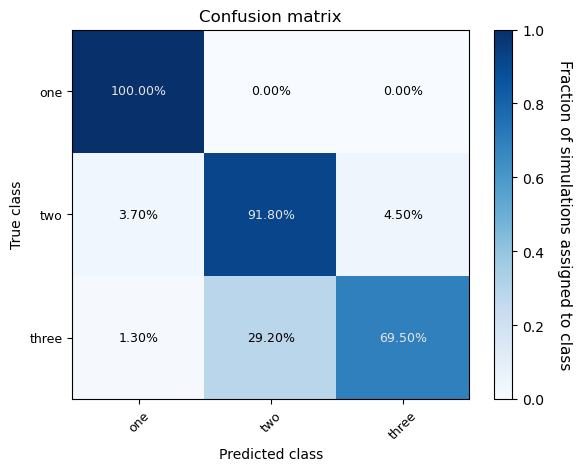

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 254  730   16]
 [ 112  103  785]]


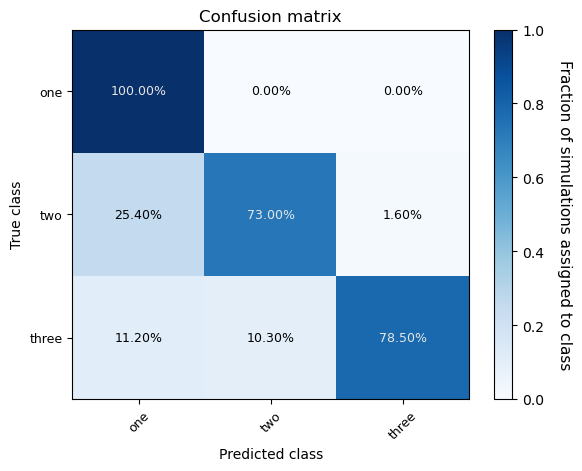

94/94 [==============================] - 0s 3ms/step


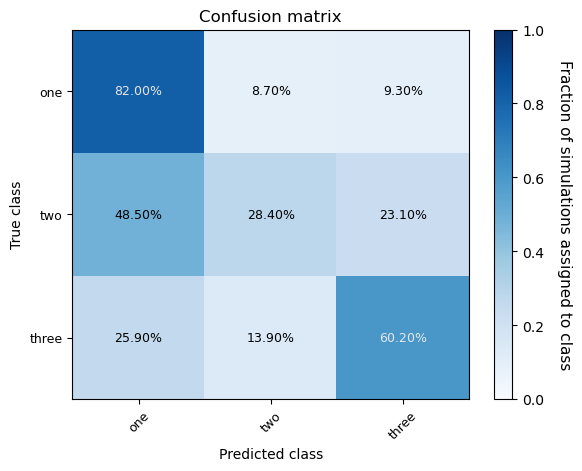

2023-03-20 17:05:20.668822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


23/94 [======>.......................] - ETA: 0s

2023-03-20 17:05:22.190134: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 17:05:22.192004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 17:05:22.192022: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-20 17:05:22.193804: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 17:05:22.193865: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


94/94 [==============================] - 3s 6ms/step


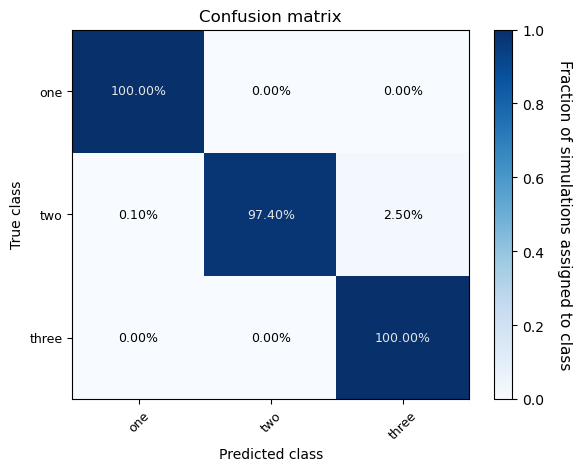

94/94 [==============================] - 1s 6ms/step


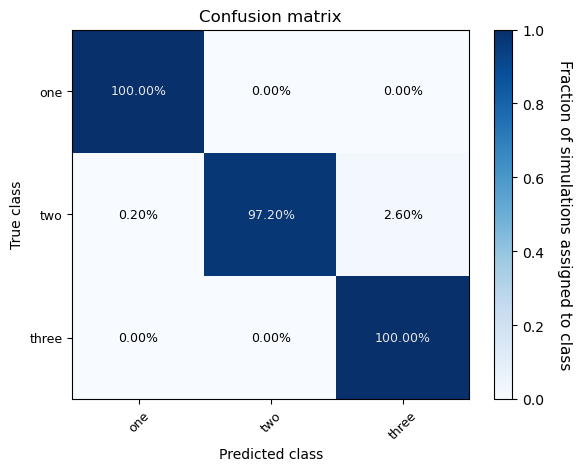

94/94 [==============================] - 1s 6ms/step


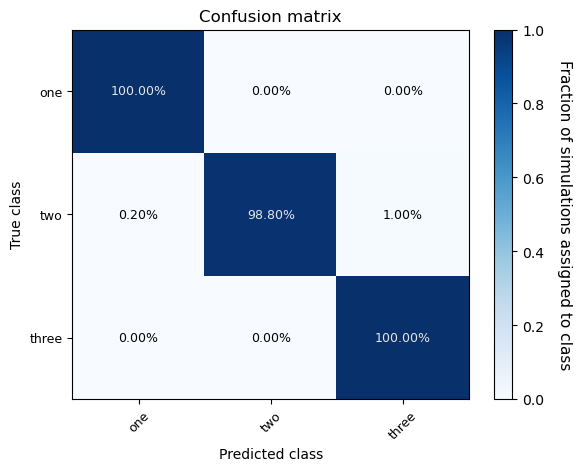

94/94 [==============================] - 1s 6ms/step


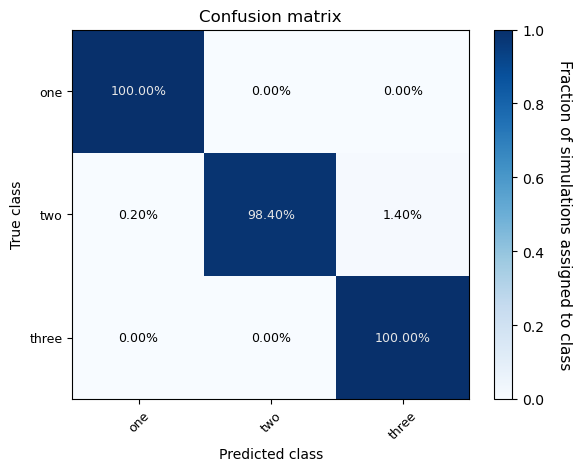

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 104  832   64]
 [  51  180  769]]


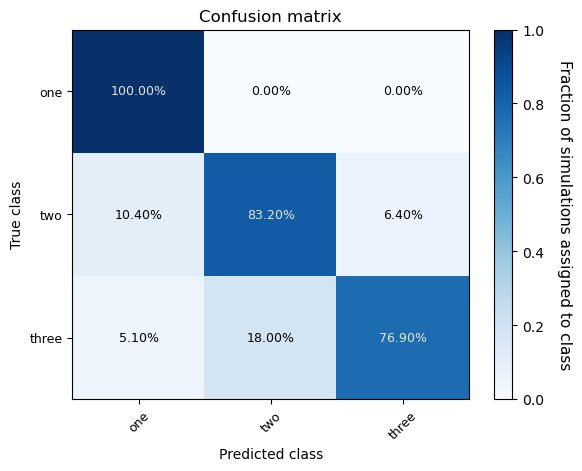

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 178  754   68]
 [  51   89  860]]


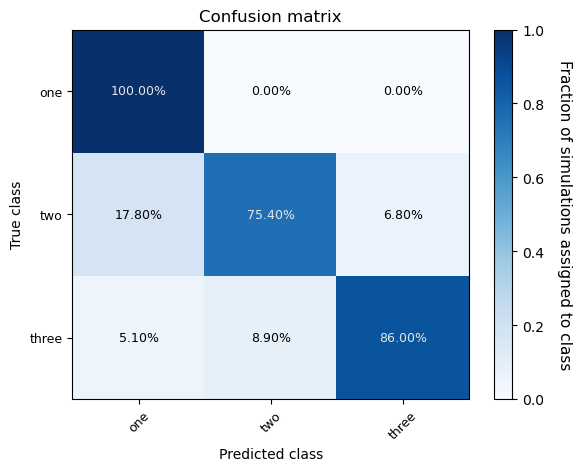

94/94 [==============================] - 0s 3ms/step


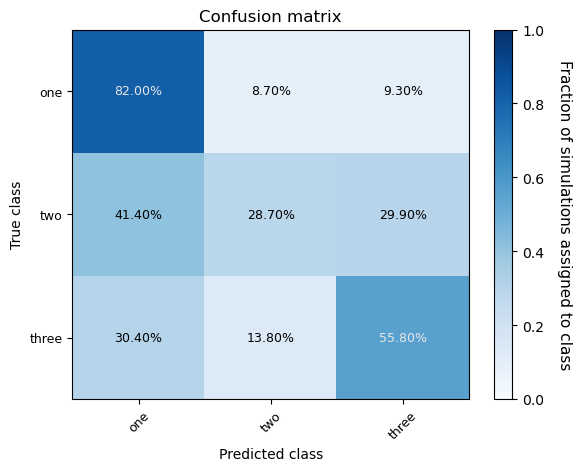

94/94 [==============================] - 0s 5ms/step


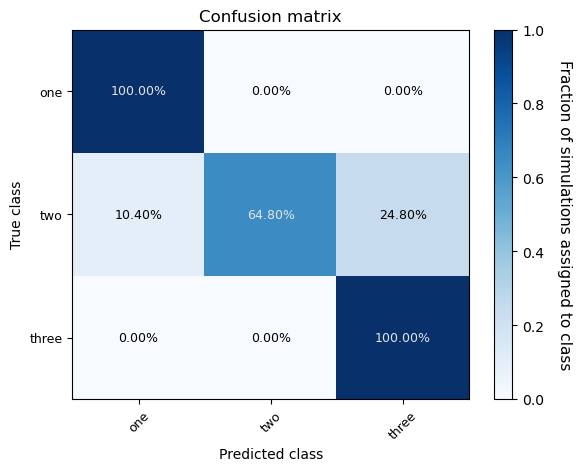

94/94 [==============================] - 1s 6ms/step


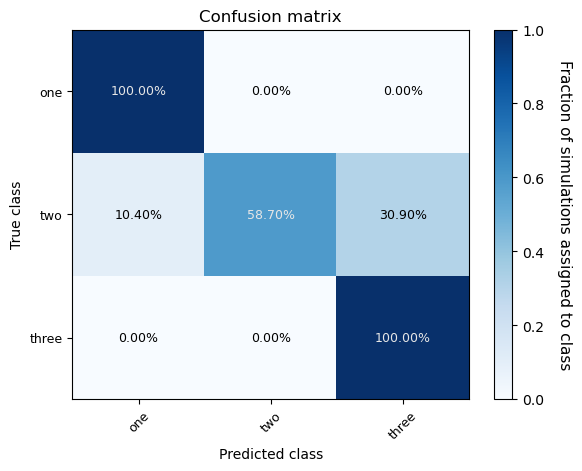

94/94 [==============================] - 1s 6ms/step


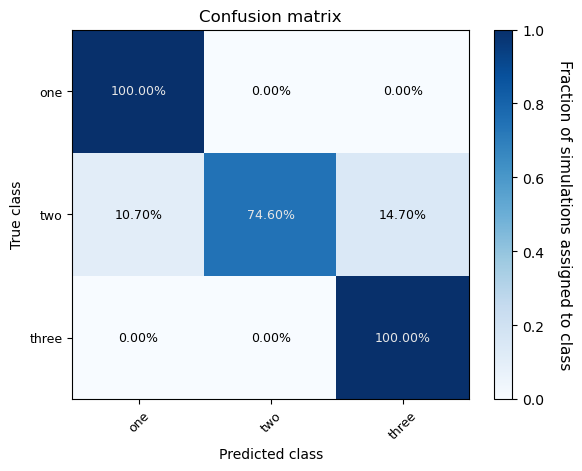

94/94 [==============================] - 1s 6ms/step


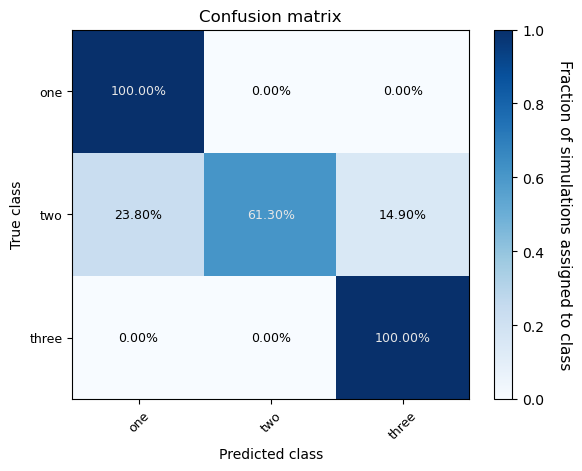

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 403  527   70]
 [ 213  126  661]]


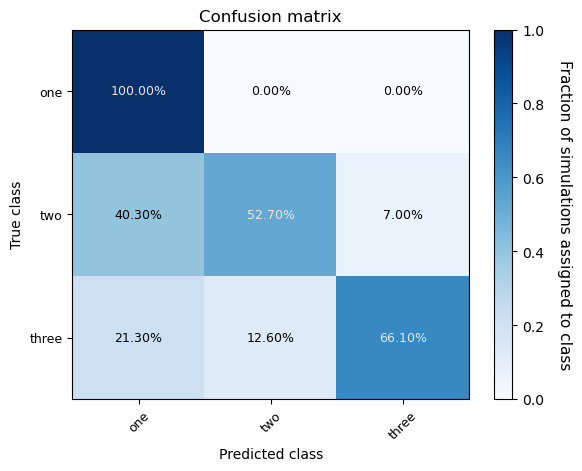

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 283  601  116]
 [  77   91  832]]


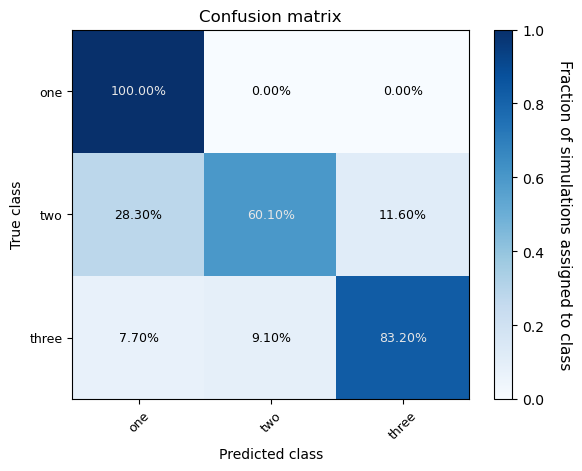

94/94 [==============================] - 0s 3ms/step


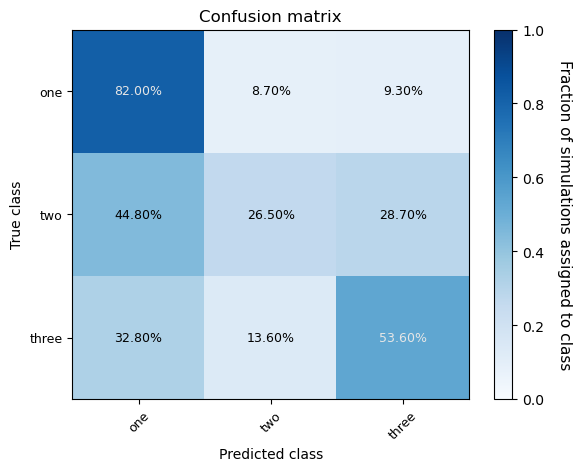

94/94 [==============================] - 0s 5ms/step


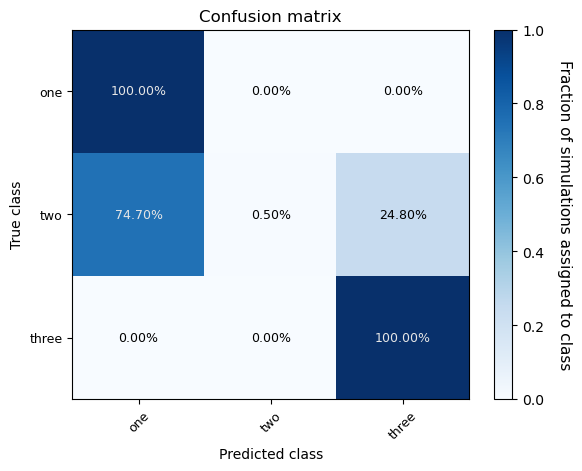

94/94 [==============================] - 1s 6ms/step


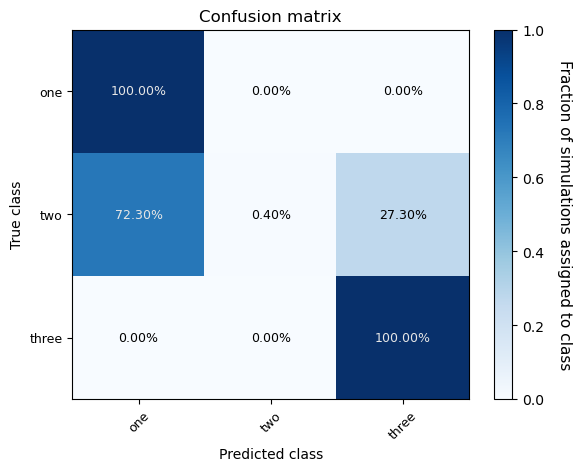

94/94 [==============================] - 1s 6ms/step


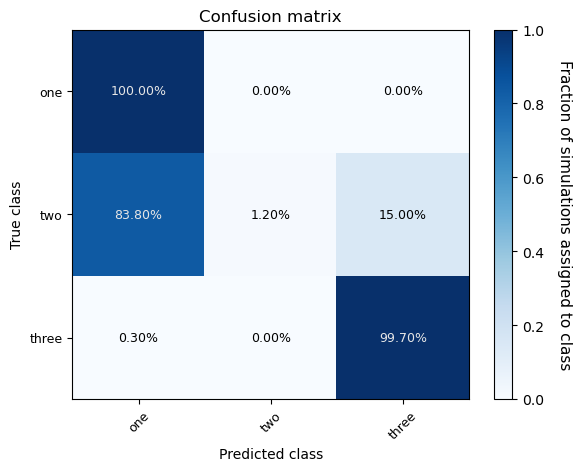

94/94 [==============================] - 1s 6ms/step


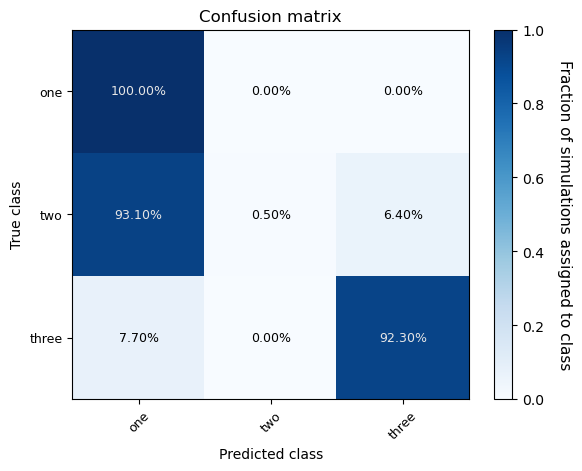

In [9]:
#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model3.predict(traits_discrete01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model4.predict(xtest01)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model5.predict([traits_BM01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model6.predict([traits_OU01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model7.predict([traits_discrete01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #8
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #9
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #10
#first get the predictions
pred = model3.predict(traits_discrete05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #11
#first get the predictions
pred = model4.predict(xtest05)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #12
#first get the predictions
pred = model5.predict([traits_BM05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #13
#first get the predictions
pred = model6.predict([traits_OU05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #14
#first get the predictions
pred = model7.predict([traits_discrete05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #15
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #16
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #17
#first get the predictions
pred = model3.predict(traits_discrete1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #18
#first get the predictions
pred = model4.predict(xtest1)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #19
#first get the predictions
pred = model5.predict([traits_BM1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #20
#first get the predictions
pred = model6.predict([traits_OU1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #21
#first get the predictions
pred = model7.predict([traits_discrete1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix


model1 = load_model('./Trained_Models/Migration01_Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('./Trained_Models/Migration01_Trained_Traits_Model_100OU.acc.mod')
model3 = load_model('./Trained_Models/Migration01_Trained_Traits_Model_100discrete.acc.mod')
model4 = load_model('./Trained_Models/Migration01_Trained_CNN_Model.acc.mod')
model5 = load_model('./Trained_Models/Migration01_Trained_Comb_Model_100BM.acc.mod')
model6 = load_model('./Trained_Models/Migration01_Trained_Comb_Model_100OU.acc.mod')
model7 = load_model('./Trained_Models/Migration01_Trained_Comb_Model_100discrete.acc.mod')
model8 = load_model('./Trained_Models/Migration05_Trained_Traits_Model_100BM.acc.mod')
model9 = load_model('./Trained_Models/Migration05_Trained_Traits_Model_100OU.acc.mod')
model10 = load_model('./Trained_Models/Migration05_Trained_Traits_Model_100discrete.acc.mod')
model11 = load_model('./Trained_Models/Migration05_Trained_CNN_Model.acc.mod')
model12 = load_model('./Trained_Models/Migration05_Trained_Comb_Model_100BM.acc.mod')
model13 = load_model('./Trained_Models/Migration05_Trained_Comb_Model_100OU.acc.mod')
model14 = load_model('./Trained_Models/Migration05_Trained_Comb_Model_100discrete.acc.mod')
model15 = load_model('./Trained_Models/Migration1_Trained_Traits_Model_100BM.acc.mod')
model16 = load_model('./Trained_Models/Migration1_Trained_Traits_Model_100OU.acc.mod')
model17 = load_model('./Trained_Models/Migration1_Trained_Traits_Model_100discrete.acc.mod')
model18 = load_model('./Trained_Models/Migration1_Trained_CNN_Model.acc.mod')
model19 = load_model('./Trained_Models/Migration1_Trained_Comb_Model_100BM.acc.mod')
model20 = load_model('./Trained_Models/Migration1_Trained_Comb_Model_100OU.acc.mod')
model21 = load_model('./Trained_Models/Migration1_Trained_Comb_Model_100discrete.acc.mod')

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [   8  865  127]
 [   1  166  833]]


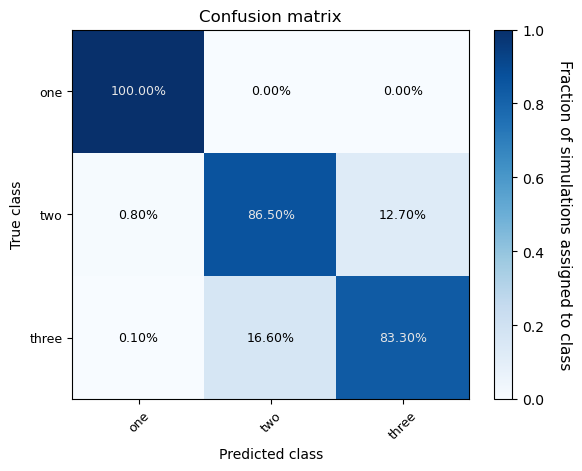

94/94 [==============================] - 0s 3ms/step
[[999   0   1]
 [138 828  34]
 [ 22  54 924]]


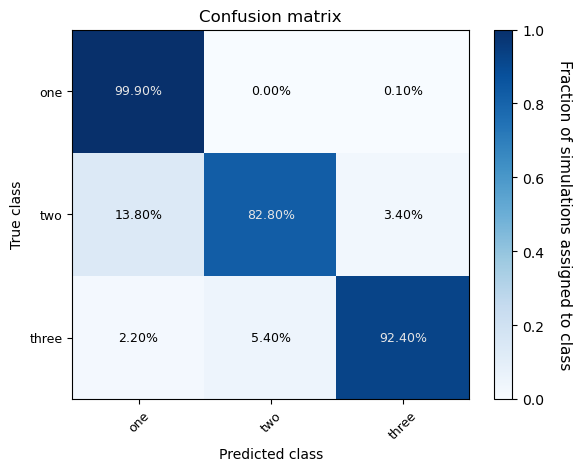

94/94 [==============================] - 0s 3ms/step


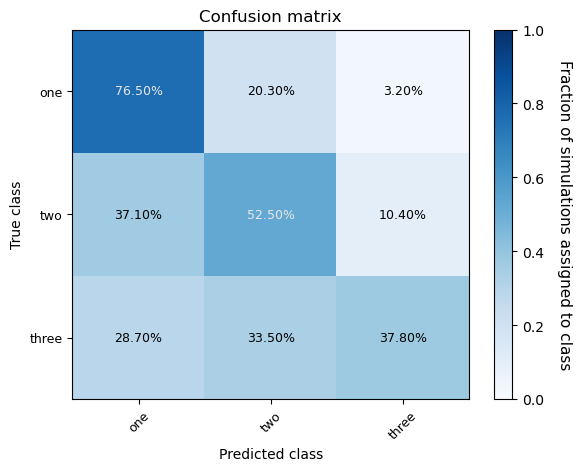

94/94 [==============================] - 1s 6ms/step


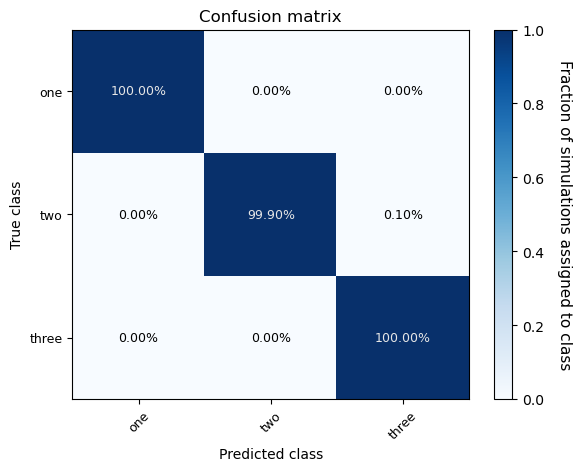

94/94 [==============================] - 1s 6ms/step


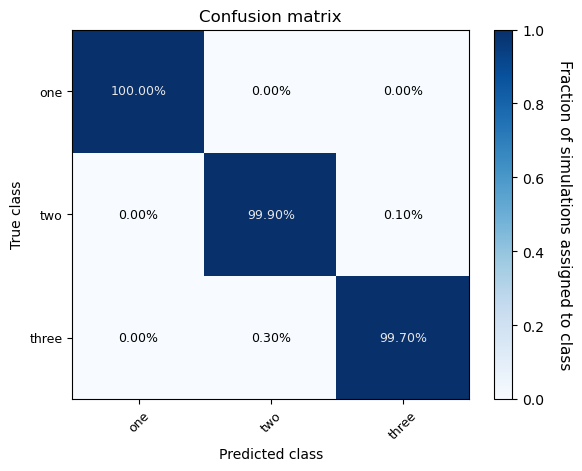

94/94 [==============================] - 1s 6ms/step


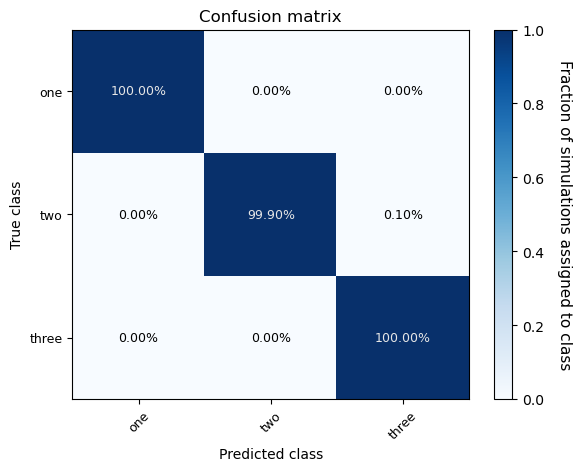

94/94 [==============================] - 1s 6ms/step


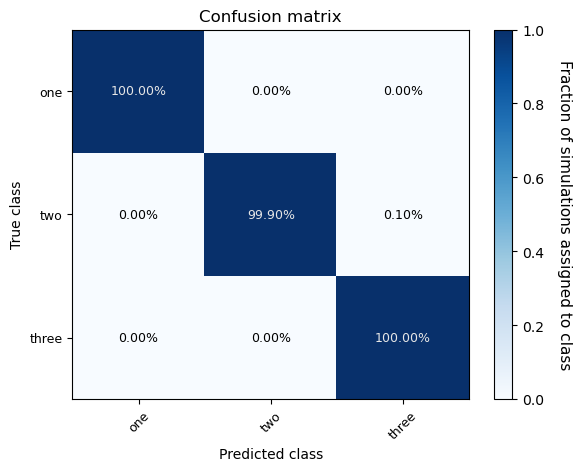

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [   8  904   88]
 [   3  132  865]]


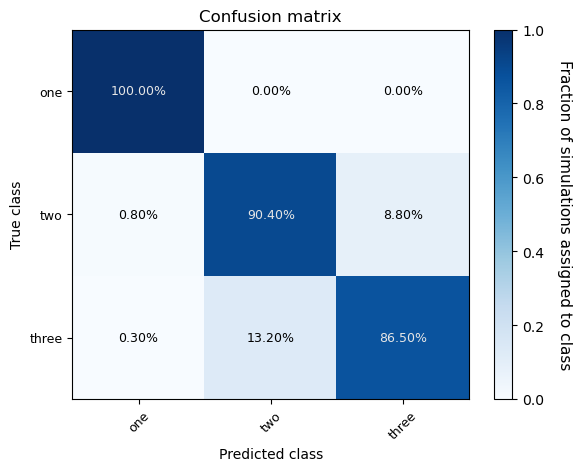

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 101  826   73]
 [  11   92  897]]


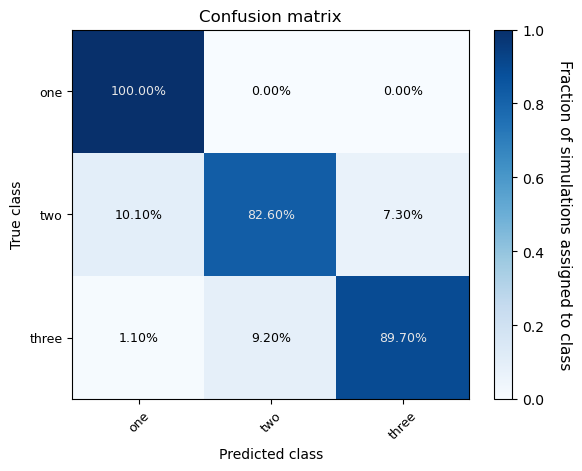

94/94 [==============================] - 0s 3ms/step


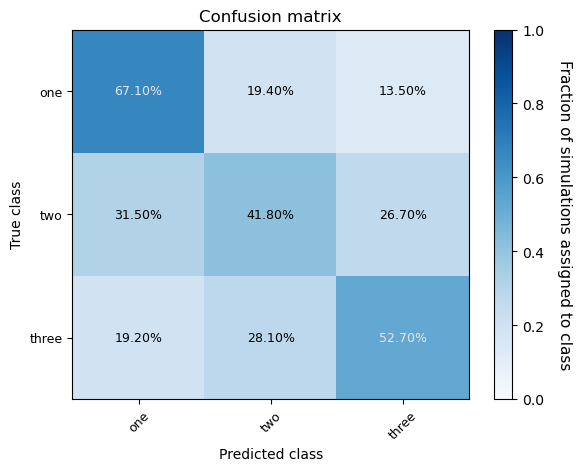

94/94 [==============================] - 1s 5ms/step


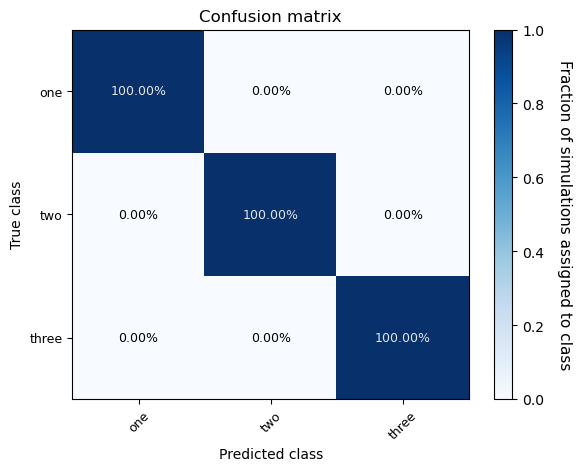

94/94 [==============================] - 1s 6ms/step


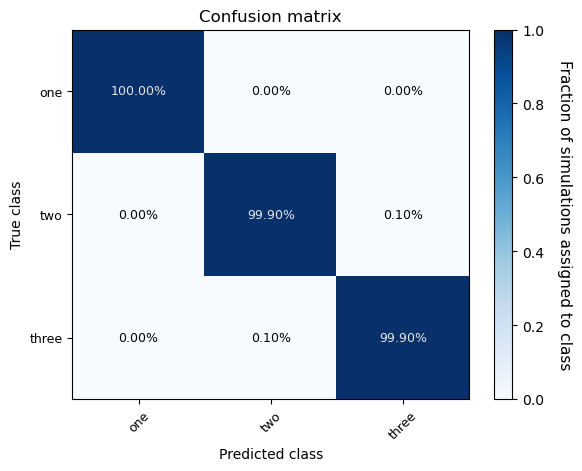

94/94 [==============================] - 1s 6ms/step


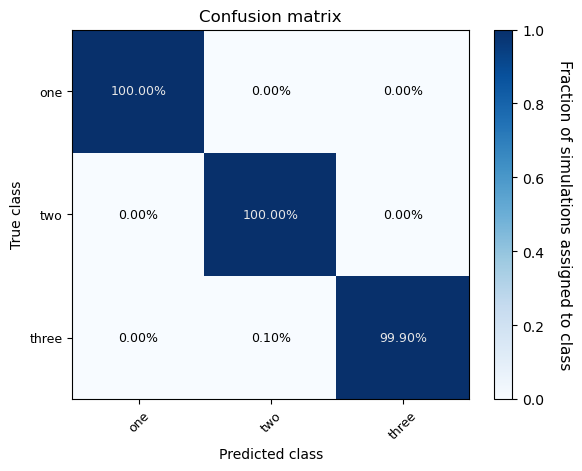

94/94 [==============================] - 1s 6ms/step


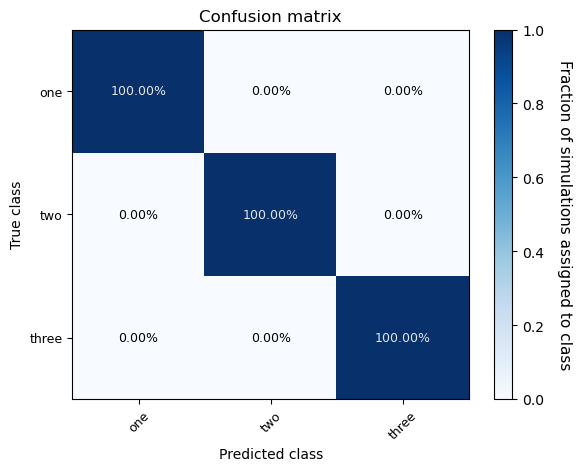

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [   6  745  249]
 [   7  307  686]]


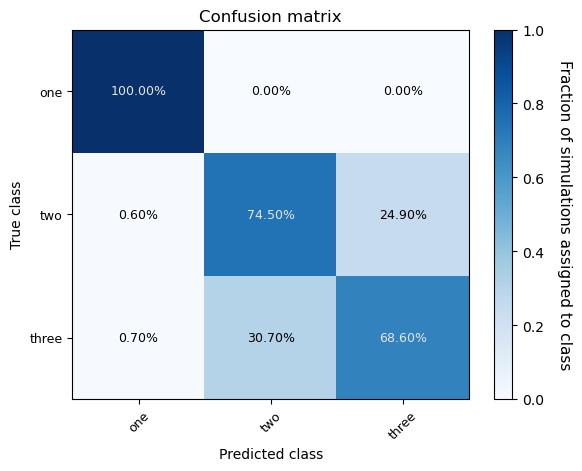

94/94 [==============================] - 0s 3ms/step
[[1000    0    0]
 [ 119  748  133]
 [   7   80  913]]


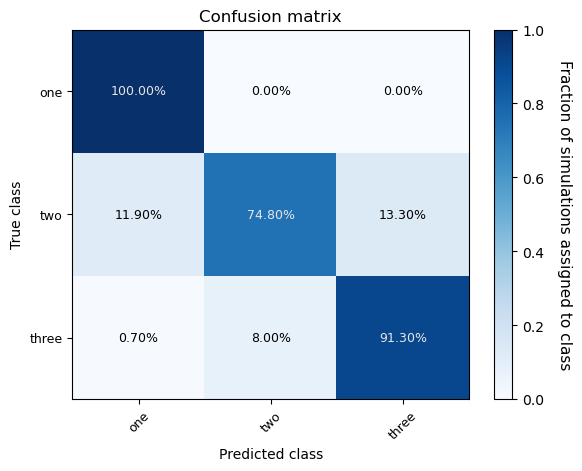

94/94 [==============================] - 0s 3ms/step


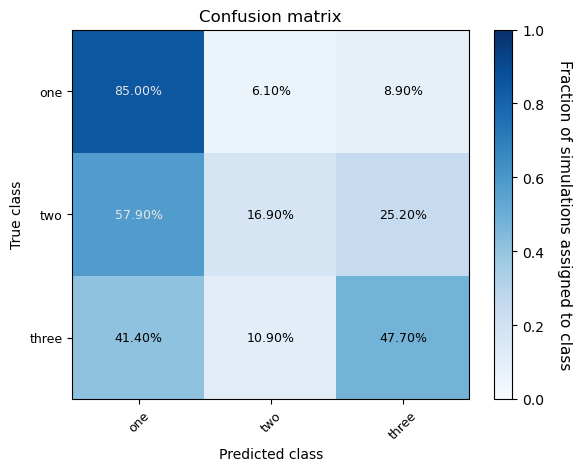

94/94 [==============================] - 1s 5ms/step


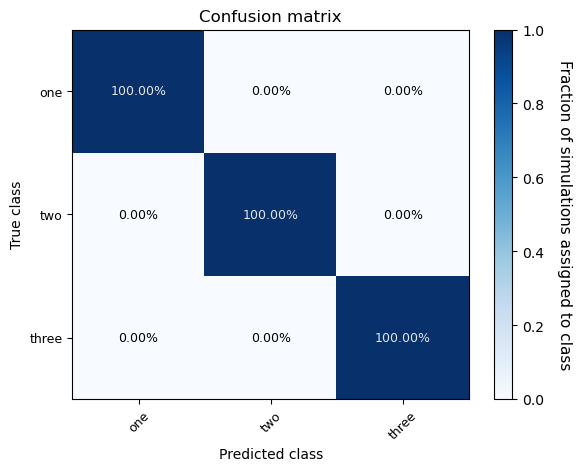

94/94 [==============================] - 1s 6ms/step


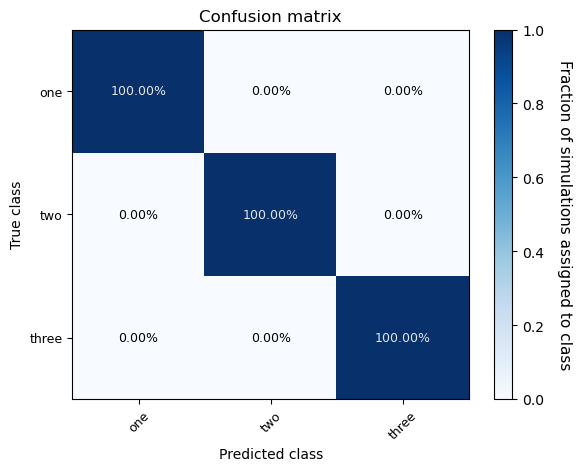

94/94 [==============================] - 1s 6ms/step


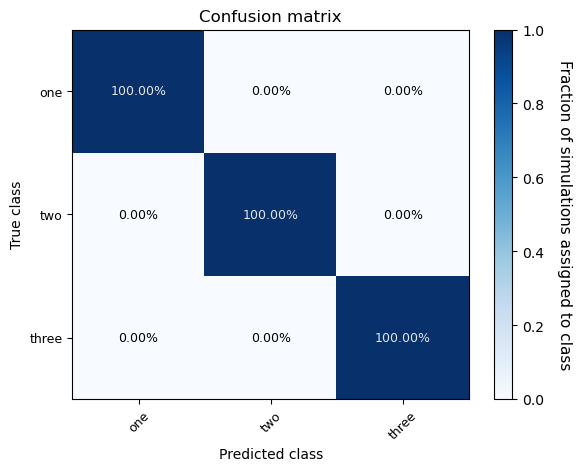

94/94 [==============================] - 1s 6ms/step


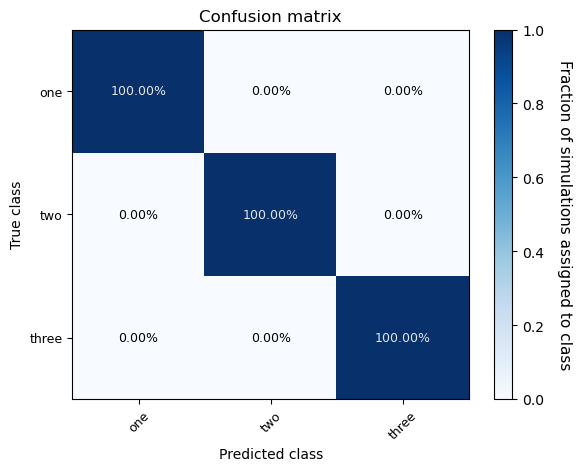

In [11]:
#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model3.predict(traits_discrete01.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model4.predict(xtest01)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model5.predict([traits_BM01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model6.predict([traits_OU01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model7.predict([traits_discrete01.reshape(3000,-1), xtest01])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model8.predict(traits_BM05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model9.predict(traits_OU05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model10.predict(traits_discrete05.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model11.predict(xtest05)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model12.predict([traits_BM05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model13.predict([traits_OU05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model14.predict([traits_discrete05.reshape(3000,-1), xtest05])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model15.predict(traits_BM1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model16.predict(traits_OU1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model17.predict(traits_discrete1.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model18.predict(xtest1)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model19.predict([traits_BM1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model20.predict([traits_OU1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model21.predict([traits_discrete1.reshape(3000,-1), xtest1])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

In [12]:
#Now predict the data simulated without migration using the networks trained with migration.
traits_BM = []
traits_BM = np.loadtxt("../testSims/traits/traits_BM.txt").reshape(3000,-1,100)
traits_BM = np.array(traits_BM)

for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 

traits_OU = []
traits_OU = np.loadtxt("../testSims/traits/traits_OU.txt").reshape(3000,-1,100)
traits_OU = np.array(traits_OU)

scalers = {}
for i in range(traits_OU.shape[2]):
    #scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    scalers[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers[i].fit_transform(traits_OU[:, :, i]) 

traits_discrete = []
traits_discrete = np.loadtxt("../testSims/traits/traits_disc.txt").reshape(3000,-1,100)
traits_discrete = np.array(traits_discrete)

u1 = np.load("../testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("../testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("../testSims/Model_3sp.npz",mmap_mode='r')

xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            xtest[arr][idx][xtest[arr][idx] == 1] = -1
            xtest[arr][idx][xtest[arr][idx] == 0] = 1
        else:
            xtest[arr][idx][xtest[arr][idx] == 0] = -1
            
ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

94/94 [==============================] - 0s 3ms/step
[[918  40  42]
 [132 779  89]
 [  8  54 938]]


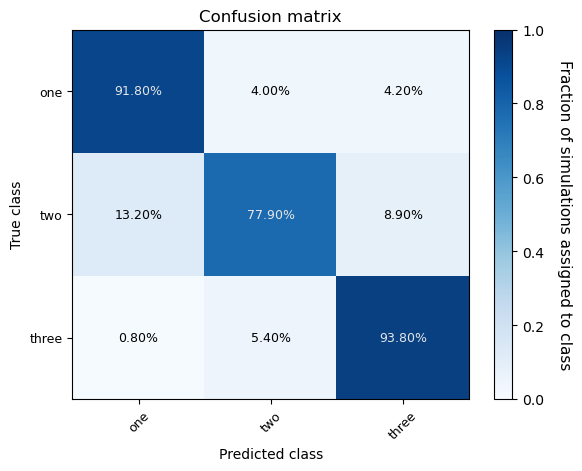

94/94 [==============================] - 0s 3ms/step
[[967  25   8]
 [106 840  54]
 [ 17  43 940]]


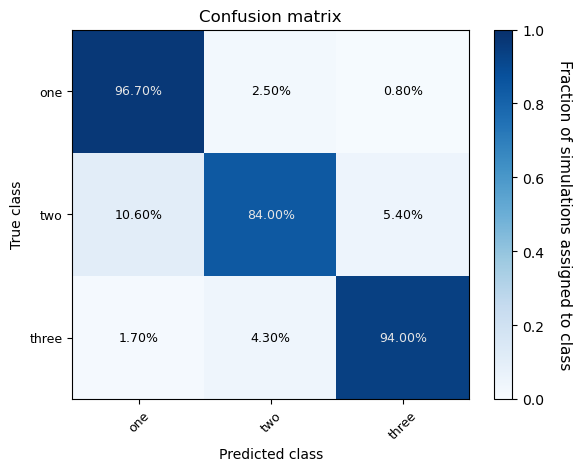

94/94 [==============================] - 0s 3ms/step


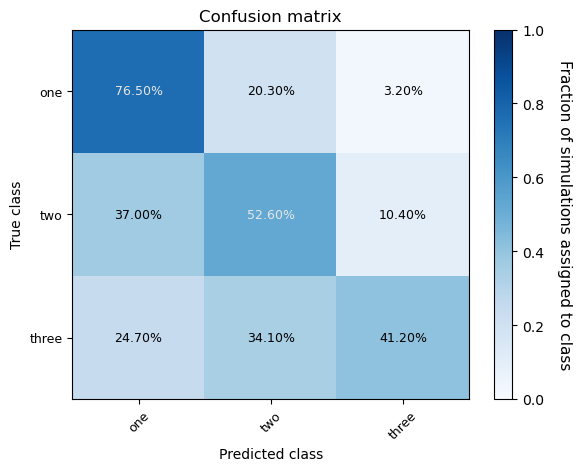

94/94 [==============================] - 1s 5ms/step


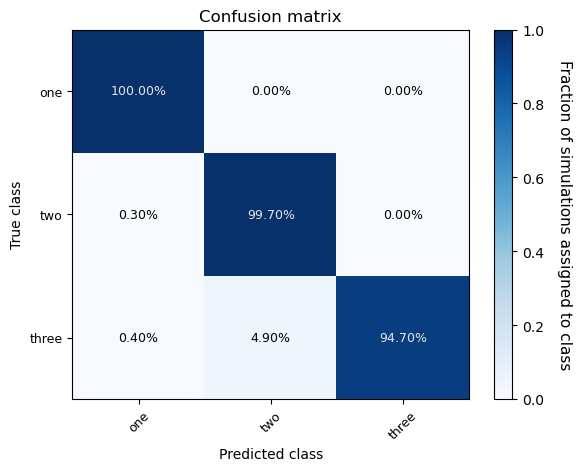

94/94 [==============================] - 1s 6ms/step


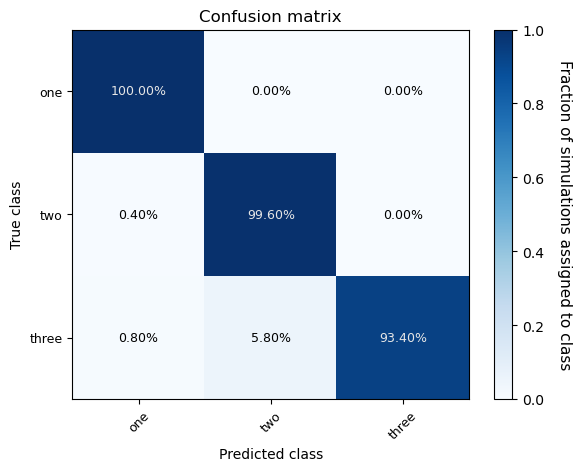

94/94 [==============================] - 1s 6ms/step


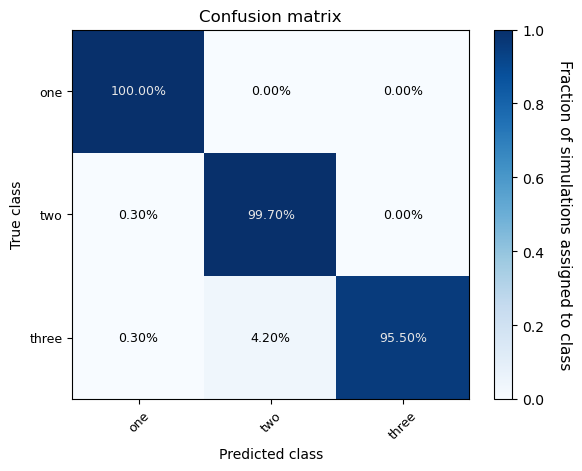

94/94 [==============================] - 1s 6ms/step


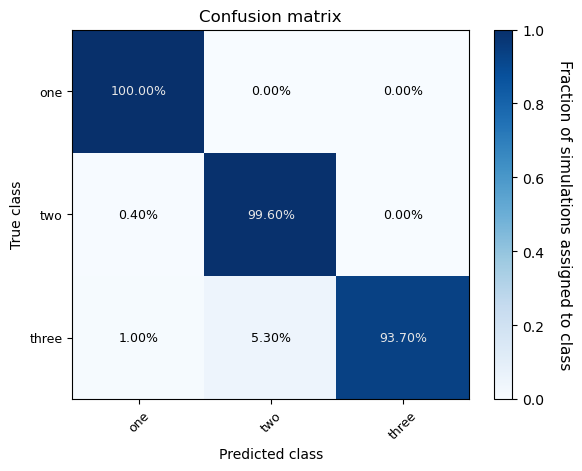

94/94 [==============================] - 0s 3ms/step
[[794 165  41]
 [ 50 899  51]
 [  2  53 945]]


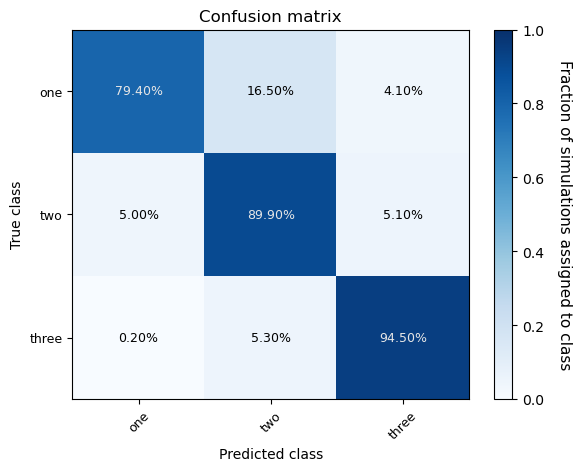

94/94 [==============================] - 0s 3ms/step
[[983  10   7]
 [176 807  17]
 [ 37  80 883]]


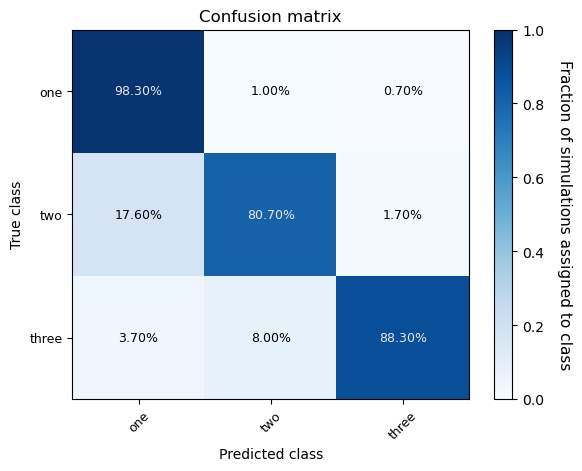

94/94 [==============================] - 0s 3ms/step


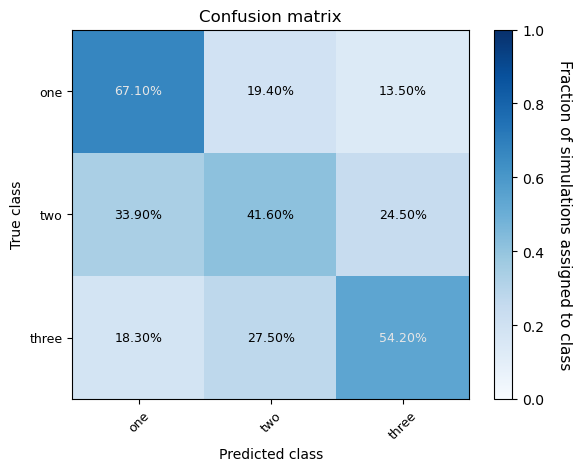

94/94 [==============================] - 1s 5ms/step


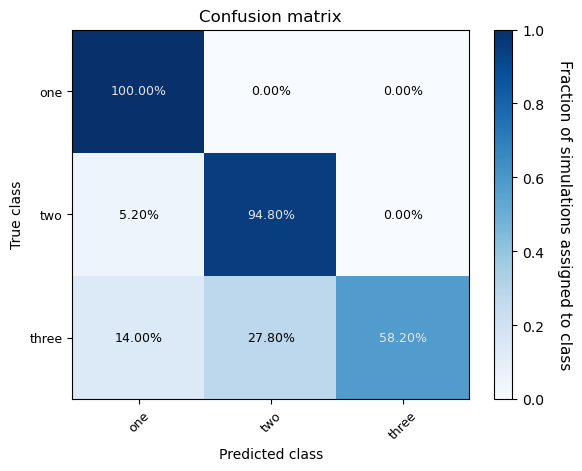

94/94 [==============================] - 1s 6ms/step


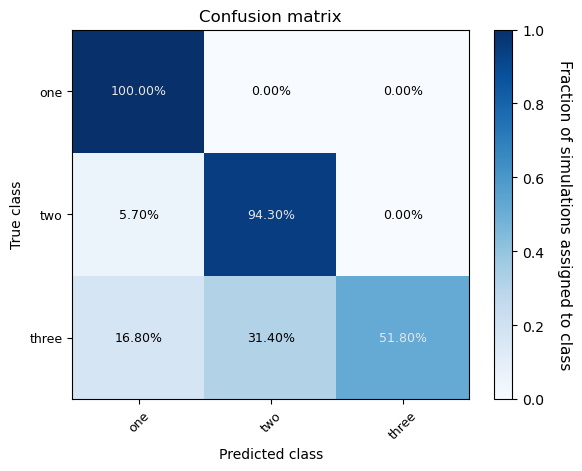

94/94 [==============================] - 1s 6ms/step


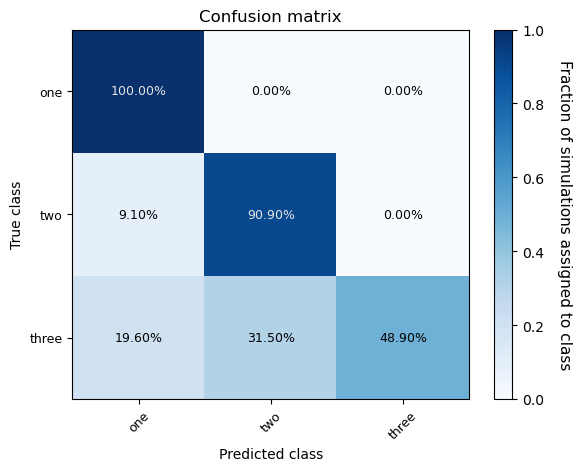

94/94 [==============================] - 1s 6ms/step


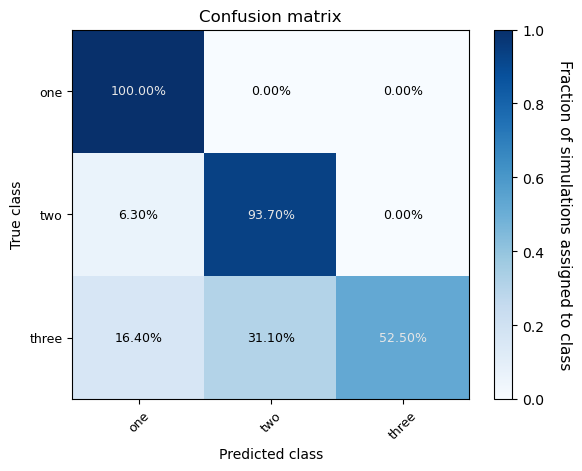

94/94 [==============================] - 0s 3ms/step
[[548 322 130]
 [ 21 810 169]
 [ 10 218 772]]


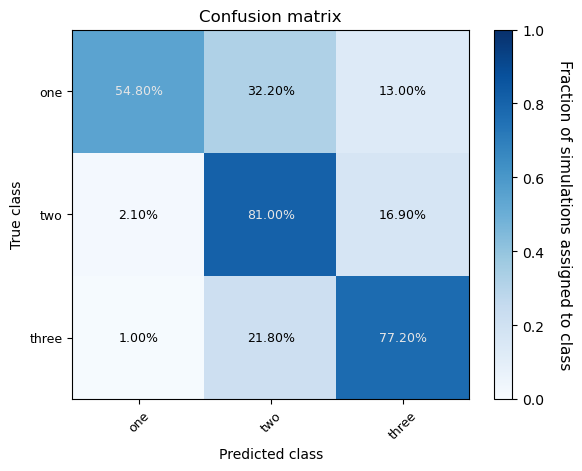

94/94 [==============================] - 0s 3ms/step
[[975  20   5]
 [156 810  34]
 [ 12  92 896]]


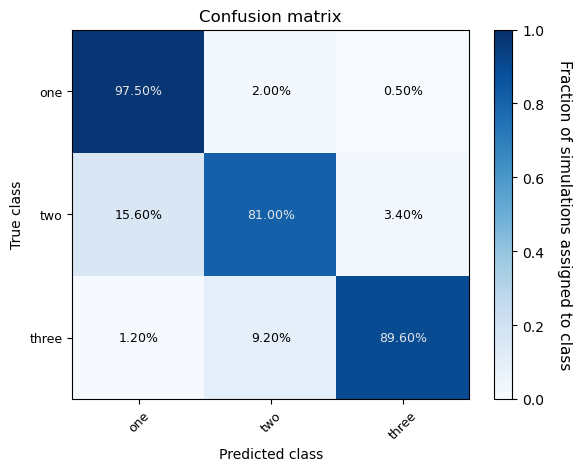

94/94 [==============================] - 0s 3ms/step


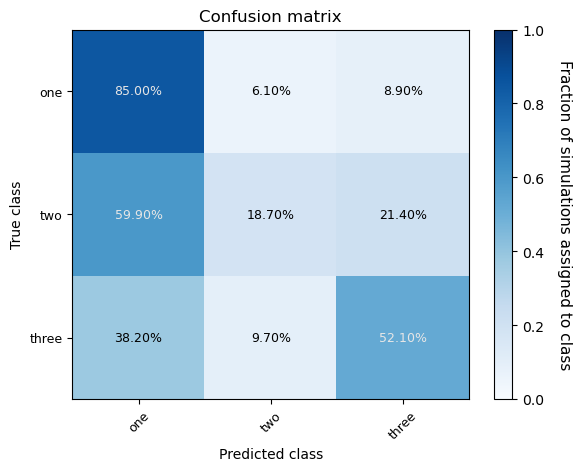

94/94 [==============================] - 1s 5ms/step


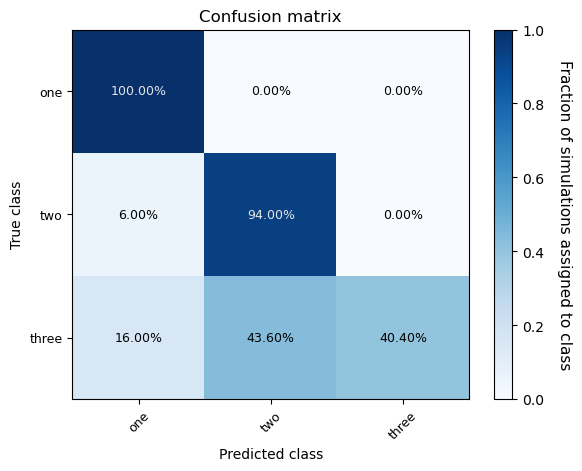

94/94 [==============================] - 1s 6ms/step


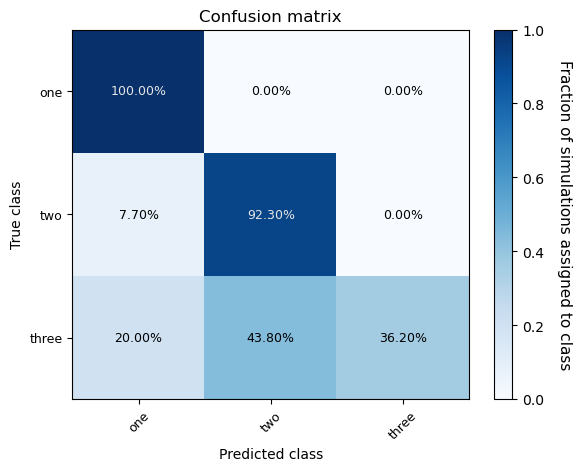

94/94 [==============================] - 1s 6ms/step


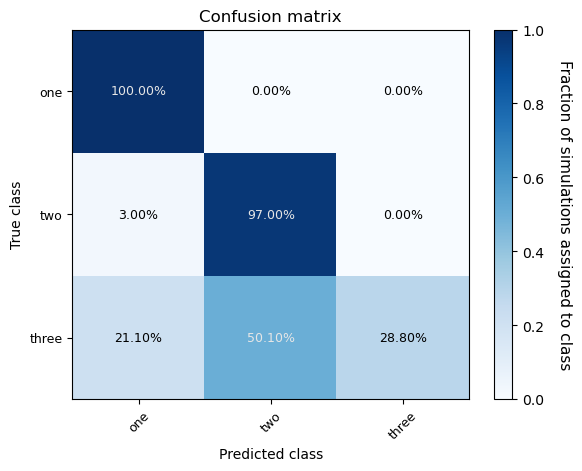

94/94 [==============================] - 1s 6ms/step


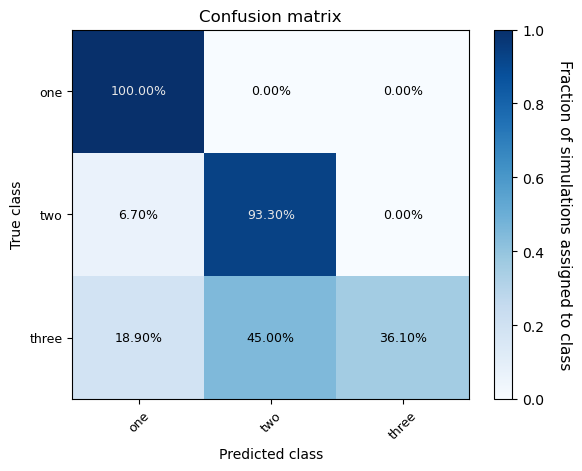

In [13]:
#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model1.predict(traits_BM.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model2.predict(traits_OU.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model3.predict(traits_discrete.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model4.predict(xtest)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model5.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model6.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model7.predict([traits_discrete.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model8.predict(traits_BM.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model9.predict(traits_OU.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model10.predict(traits_discrete.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model11.predict(xtest)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model12.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model13.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model14.predict([traits_discrete.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model15.predict(traits_BM.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model16.predict(traits_OU.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model17.predict(traits_discrete.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model18.predict(xtest)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model19.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model20.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model21.predict([traits_discrete.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()